# ISPR Home Work 1

### Student: Moroni Luca
### Mat: ----

## Assignment: 1

## Importing used libraries

In [1]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 3.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf

## Reduce dataset to 'Applicances' column

Run this code the first time you have to deal with the dataset energydata_complete take from:
https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction#

In [7]:
## -> needed to be executed only the first time, to preprocess the data

# dataset = pd.read_csv("energydata_complete.csv")

# reduced_dataset = dataset["Appliances"]

# print(reduced_dataset.size)

# print(reduced_dataset.head())

# reduced_dataset.to_csv("sample_data/energydata_Appliances.csv", index=False)

In [3]:
appliances_sequence = pd.read_csv("energydata_Appliances.csv", index_col=None).to_numpy()

appliances_sequence = appliances_sequence.flatten()

print(f"Lenght of the sequence: {appliances_sequence.size}")
print(f"Mean of the sequence: {np.mean(appliances_sequence)}")
print(f"Min of the sequence: {np.min(appliances_sequence)}")
print(f"Max of the sequence: {np.max(appliances_sequence)}")

Lenght of the sequence: 19735
Mean of the sequence: 97.6949581960983
Min of the sequence: 10
Max of the sequence: 1080


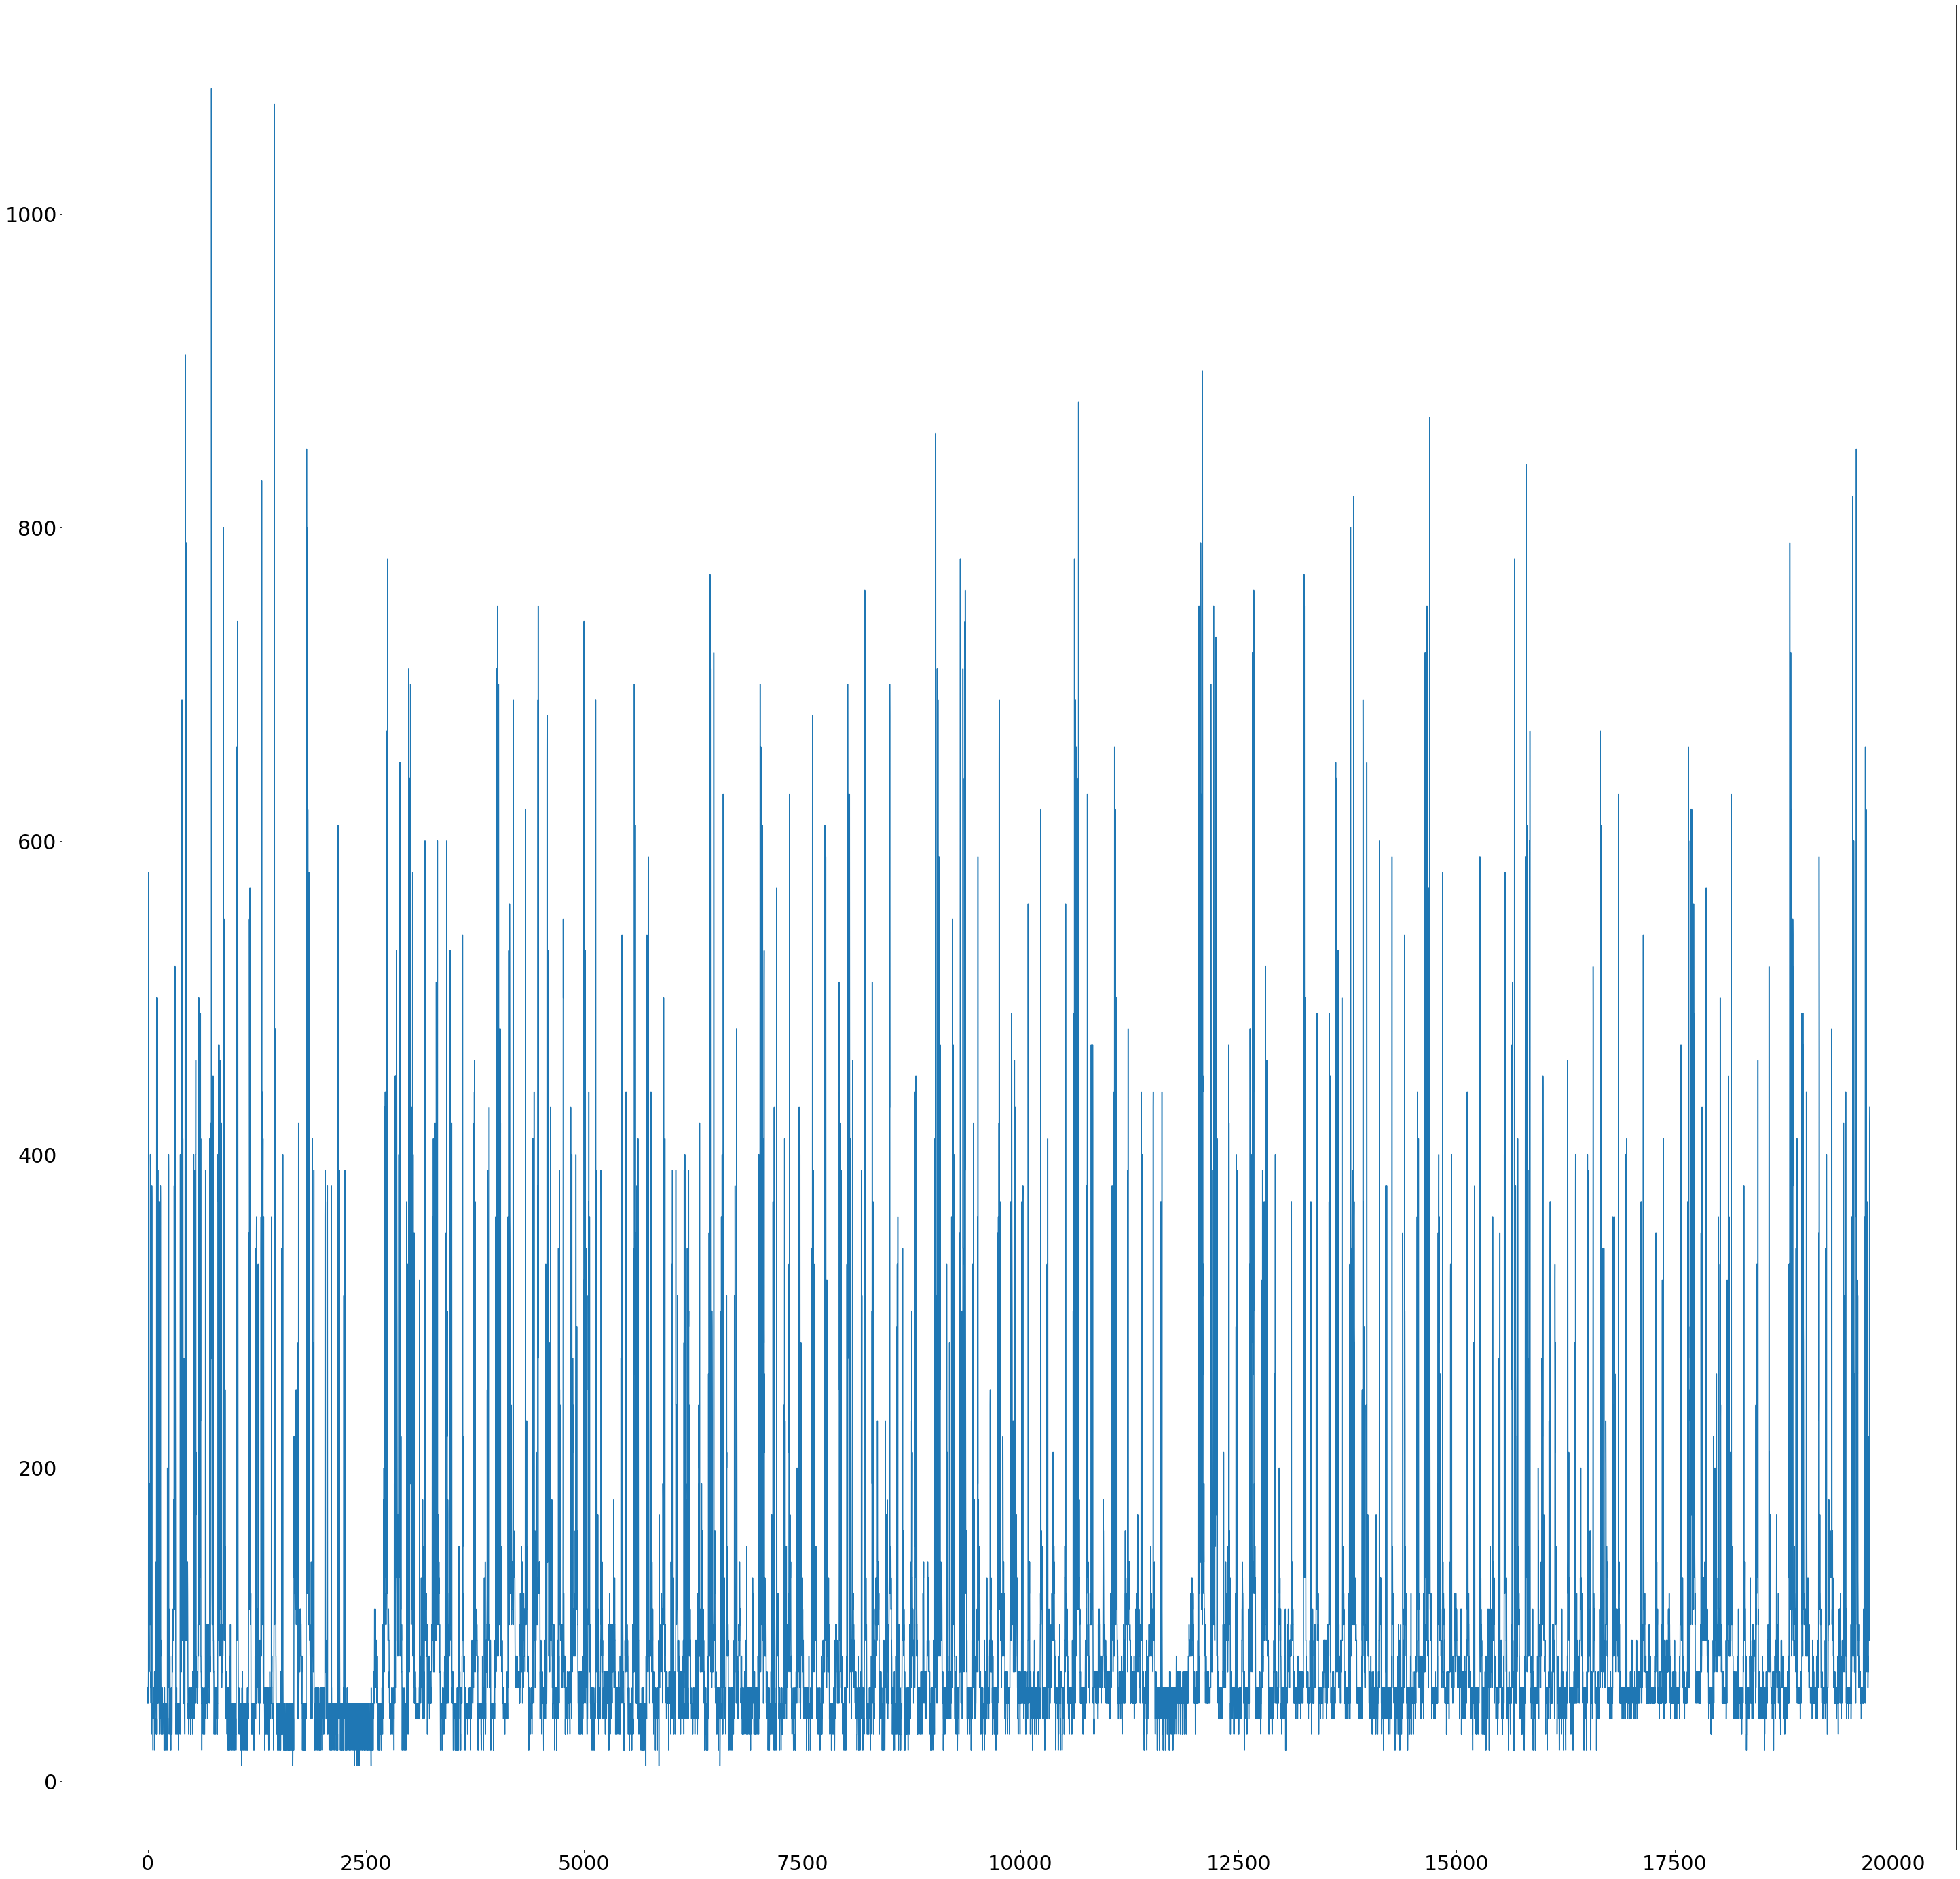

In [9]:
plt.figure(figsize=(50,50))
plt.plot(appliances_sequence)
plt.show()

# Plot of the appliance_sequence

### Autocorrelation

In this section I computed the Autoccorrelation function, I've done this assuming that the given sequence has constant covariance for given the lag.

From the description of the sequence we can infer that the sequence can have a kind of period, it can be reasonable that the maximal of the auto-correlation function is about days or weeks, so 6*24 (= 144) for day periods or 144*7 (= 1008) for week periods.
Now we compute the autocorrelation plot with maximum lag of 2 weeks (= 2016) and we'll see what happend.

In [10]:
day = 6*24
week = day*7

In [11]:
autocorrelation = acf(appliances_sequence, nlags=week*2)

In [12]:
# remove first 20 elements from the counts due the strong autocorrelation of the sequence with itself
period = np.argmax(autocorrelation[20:]) + 20
print("Found maxima: ", period)

Found maxima:  144


maxima in 144, sounds familiar!, the period is a day?.
We can see that there are some points where the ac curve have local maxima, that points are day-wise.

It can be reasonable to say that the sequence has a period of one day (, or one week) but the auto-correlation value with lag of one day (144) is not so high, only 0.2.

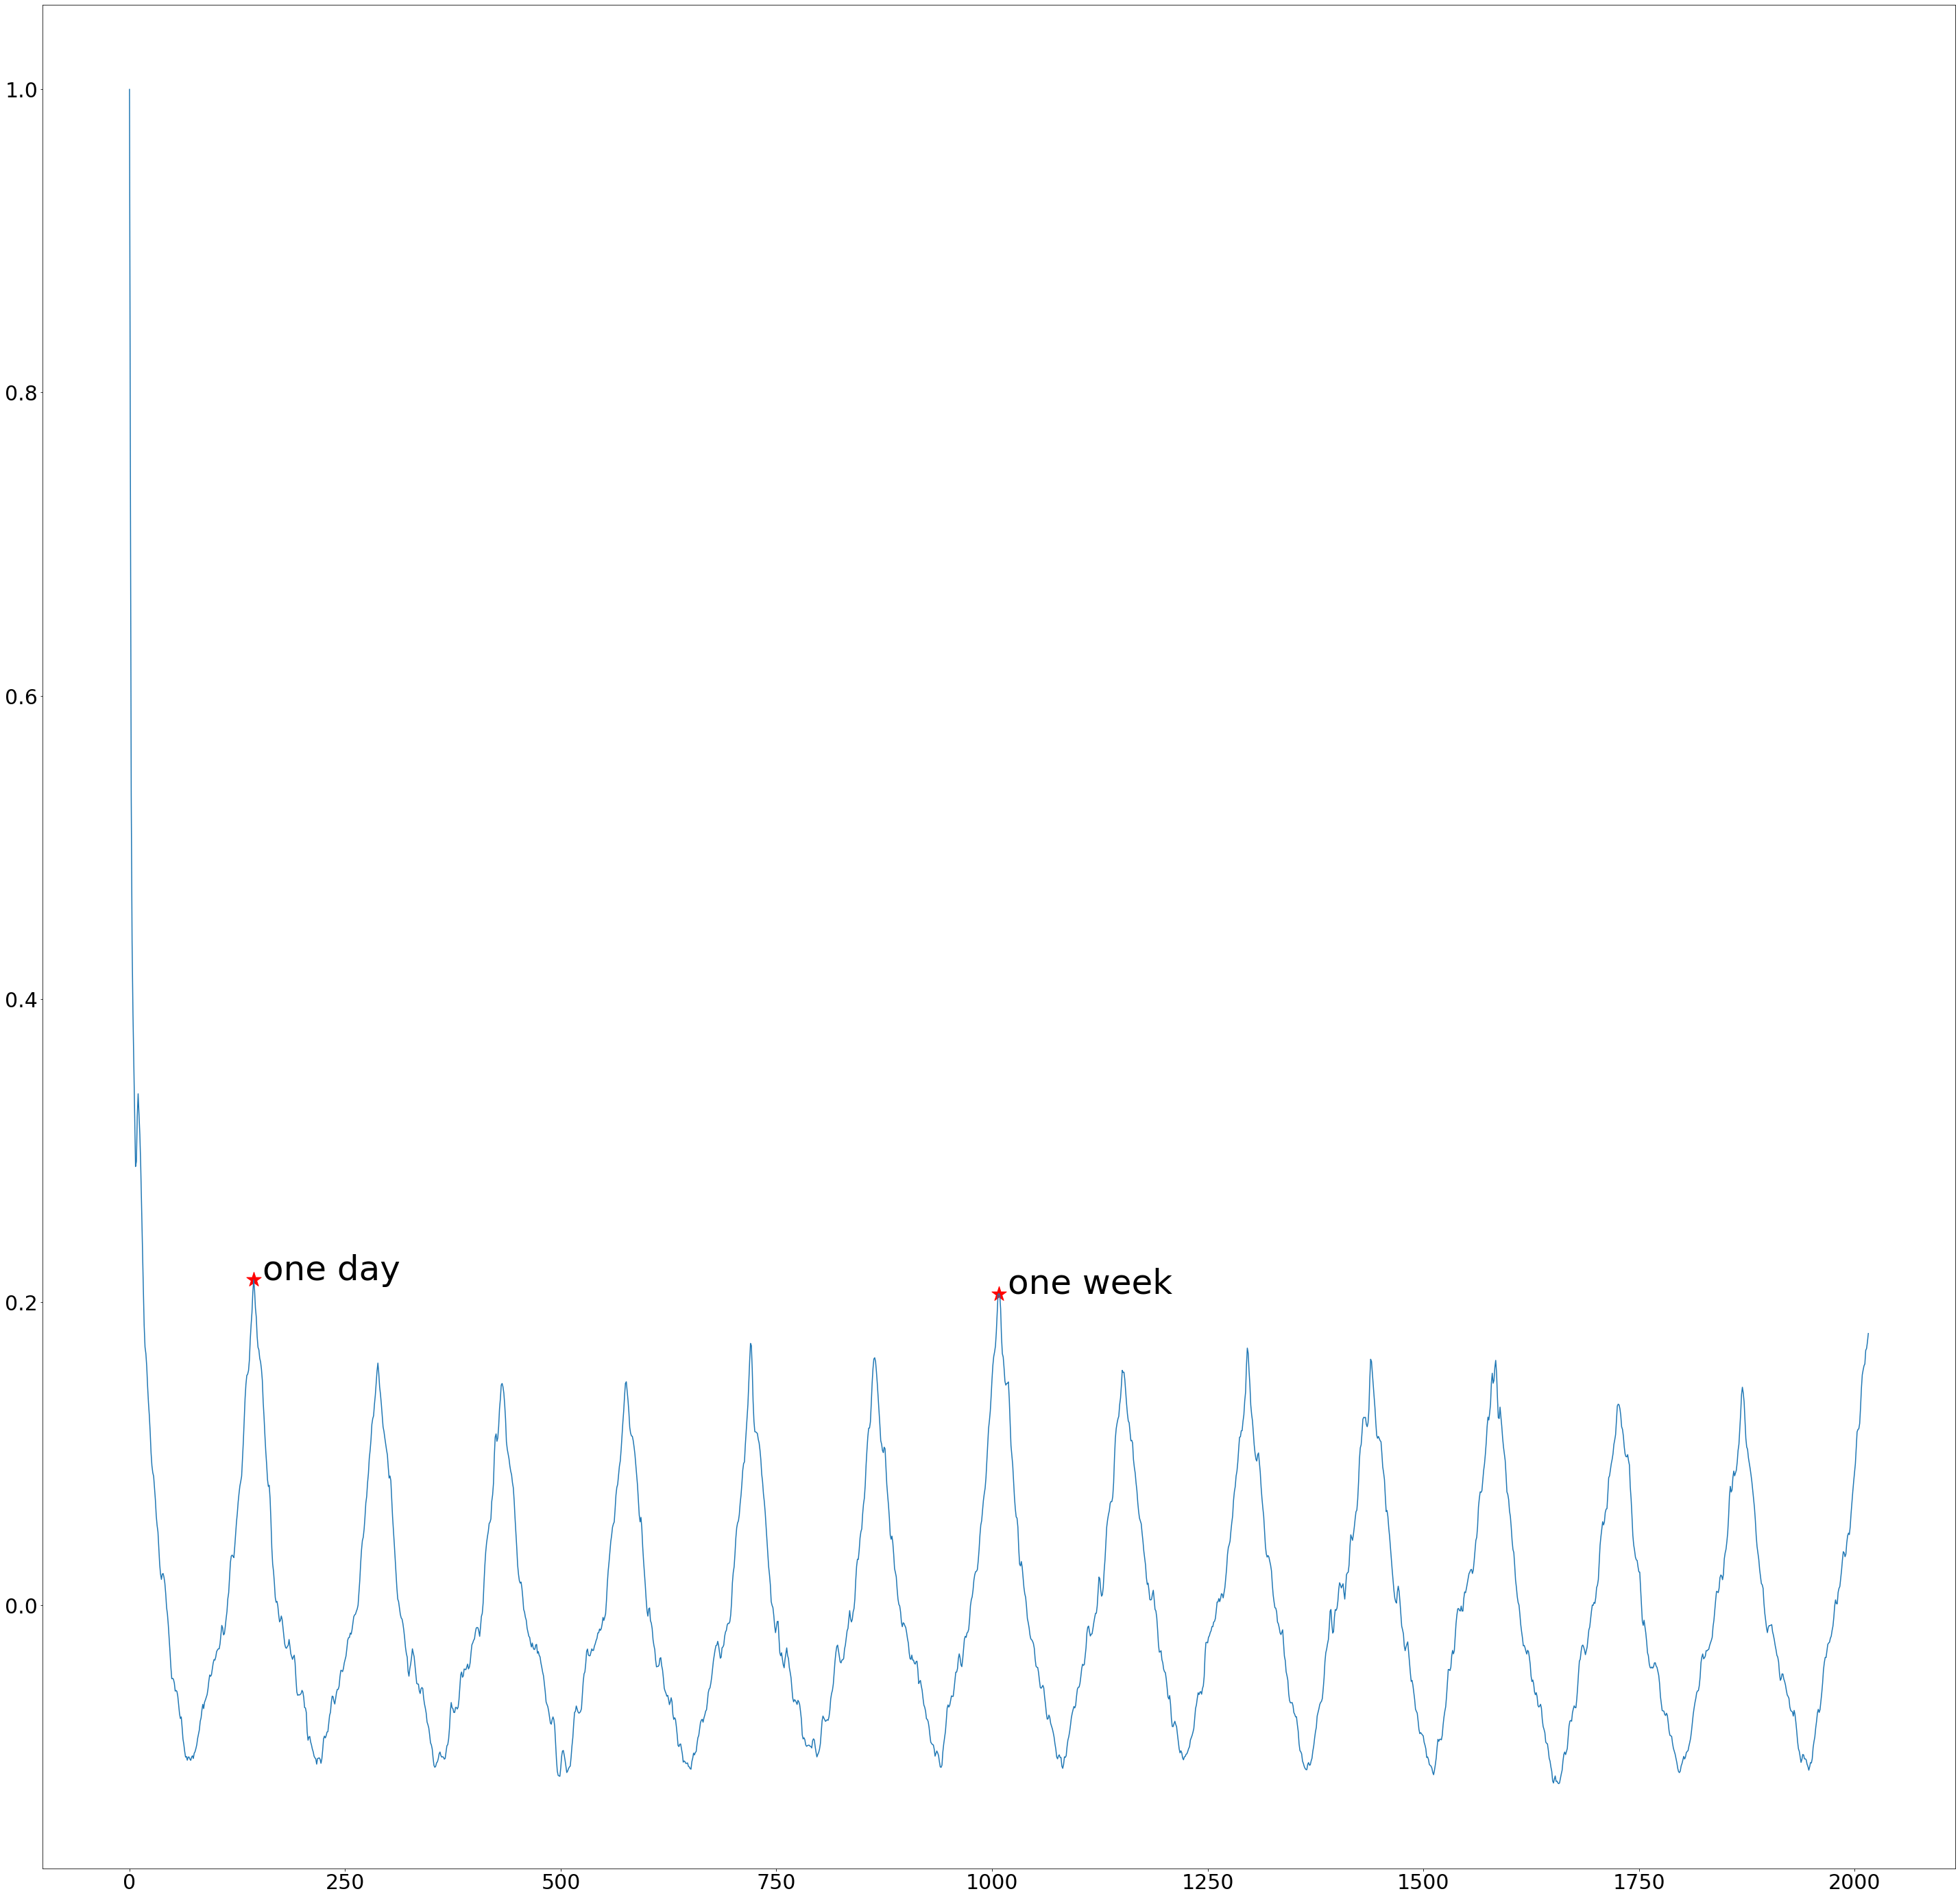

In [13]:
plt.figure(figsize=(50,50))
plt.plot(autocorrelation)
plt.scatter(day, autocorrelation[day], marker='*', color='red', s=500)
plt.text(day+10, autocorrelation[day], "one day", fontsize=50)
plt.scatter(week, autocorrelation[week], marker='*', color='red', s=500)
plt.text(week+10, autocorrelation[week], "one week", fontsize=50)
plt.show()

# Plot of the autocorrelation function of the appliances sequence, by max lag of 2 weeks

## Trend Analysis

A trend is a continued increase or decrease in the series over time. There can be benefit in identifying, modeling, and even removing trend information from your time series dataset.


### There is a trend?

From the plot of the un-touched time serie seems that there isn't a trend, but we can use the 'seasonal_decompose' function using period=day (the maximum of the autocorrelation plot), to see if there is a trend in the decomposition.

seasonal_decomposition is a function that decompose a time series in it's three foundamental components:

- Trend: general systematic linear or non linear component that change over time and doesn't repeat.
- Seasonality: general systematic linear or non linear component that change over time and does repeat.
- Noise.


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(appliances_sequence, model="additive", period = week, extrapolate_trend=week)

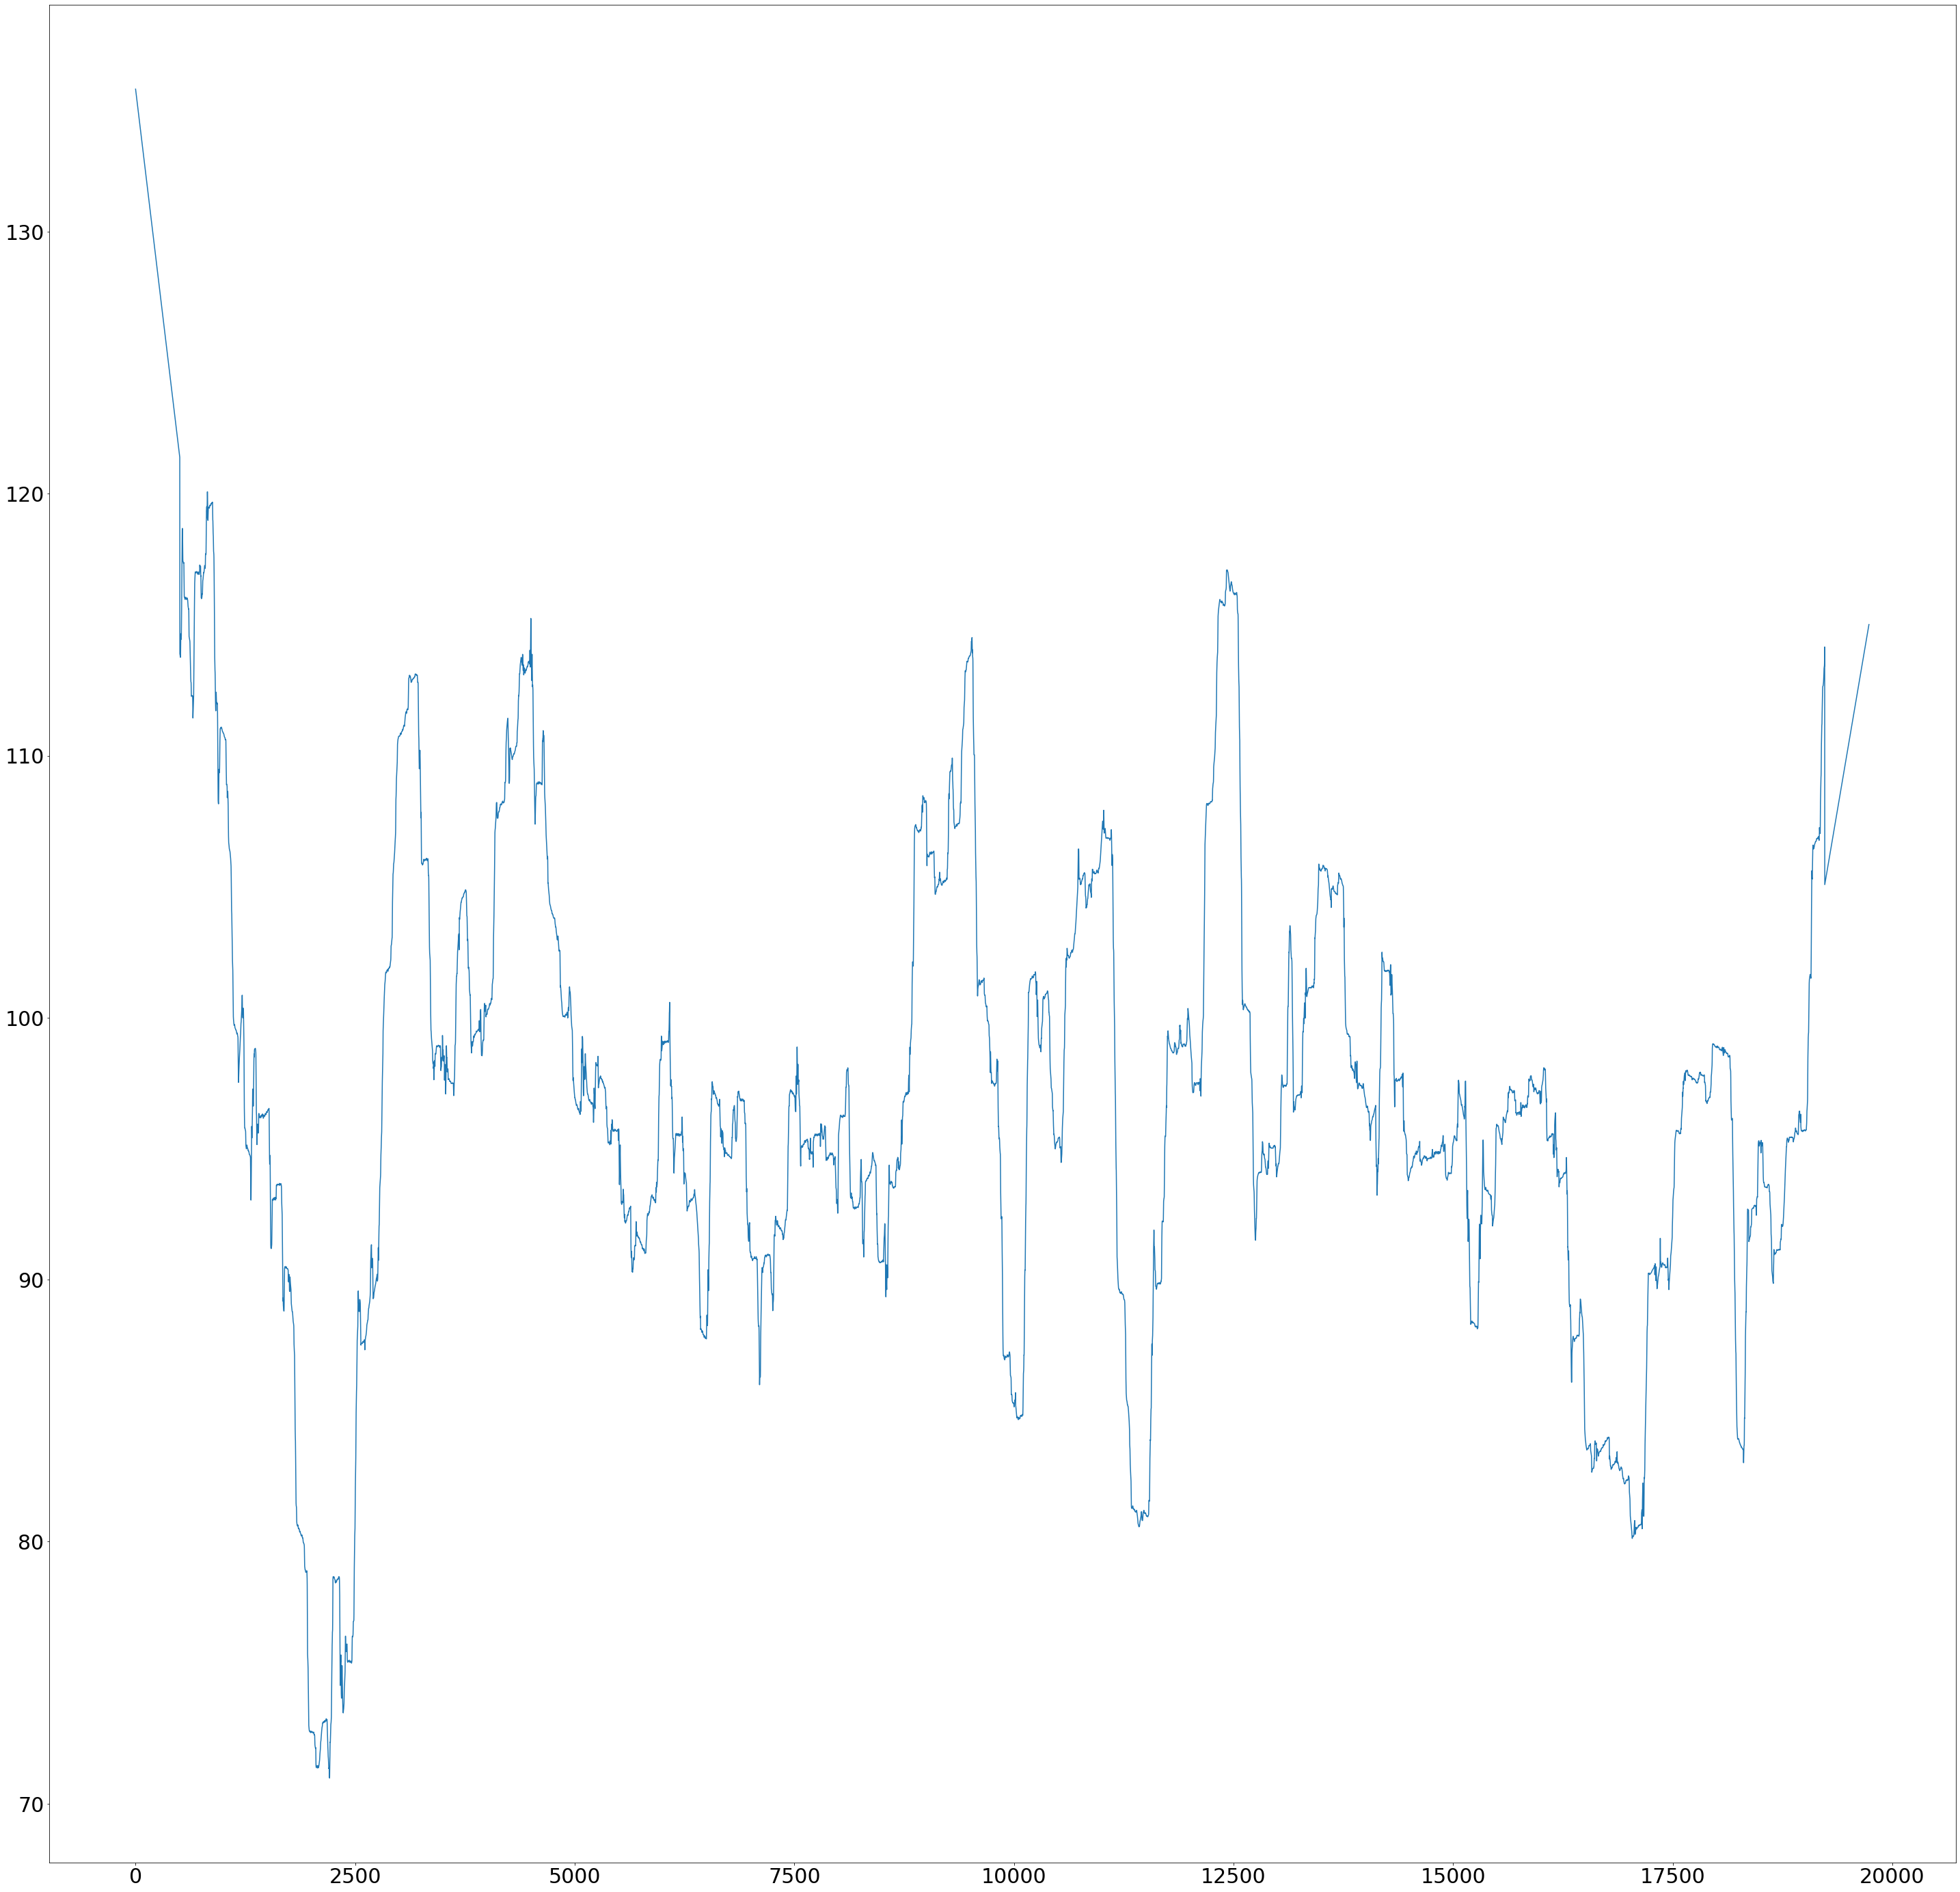

In [15]:
plt.figure(figsize=(50,50))
plt.plot(decomposition.trend)
plt.show()

# Plot of the trend in the decomposed sequence

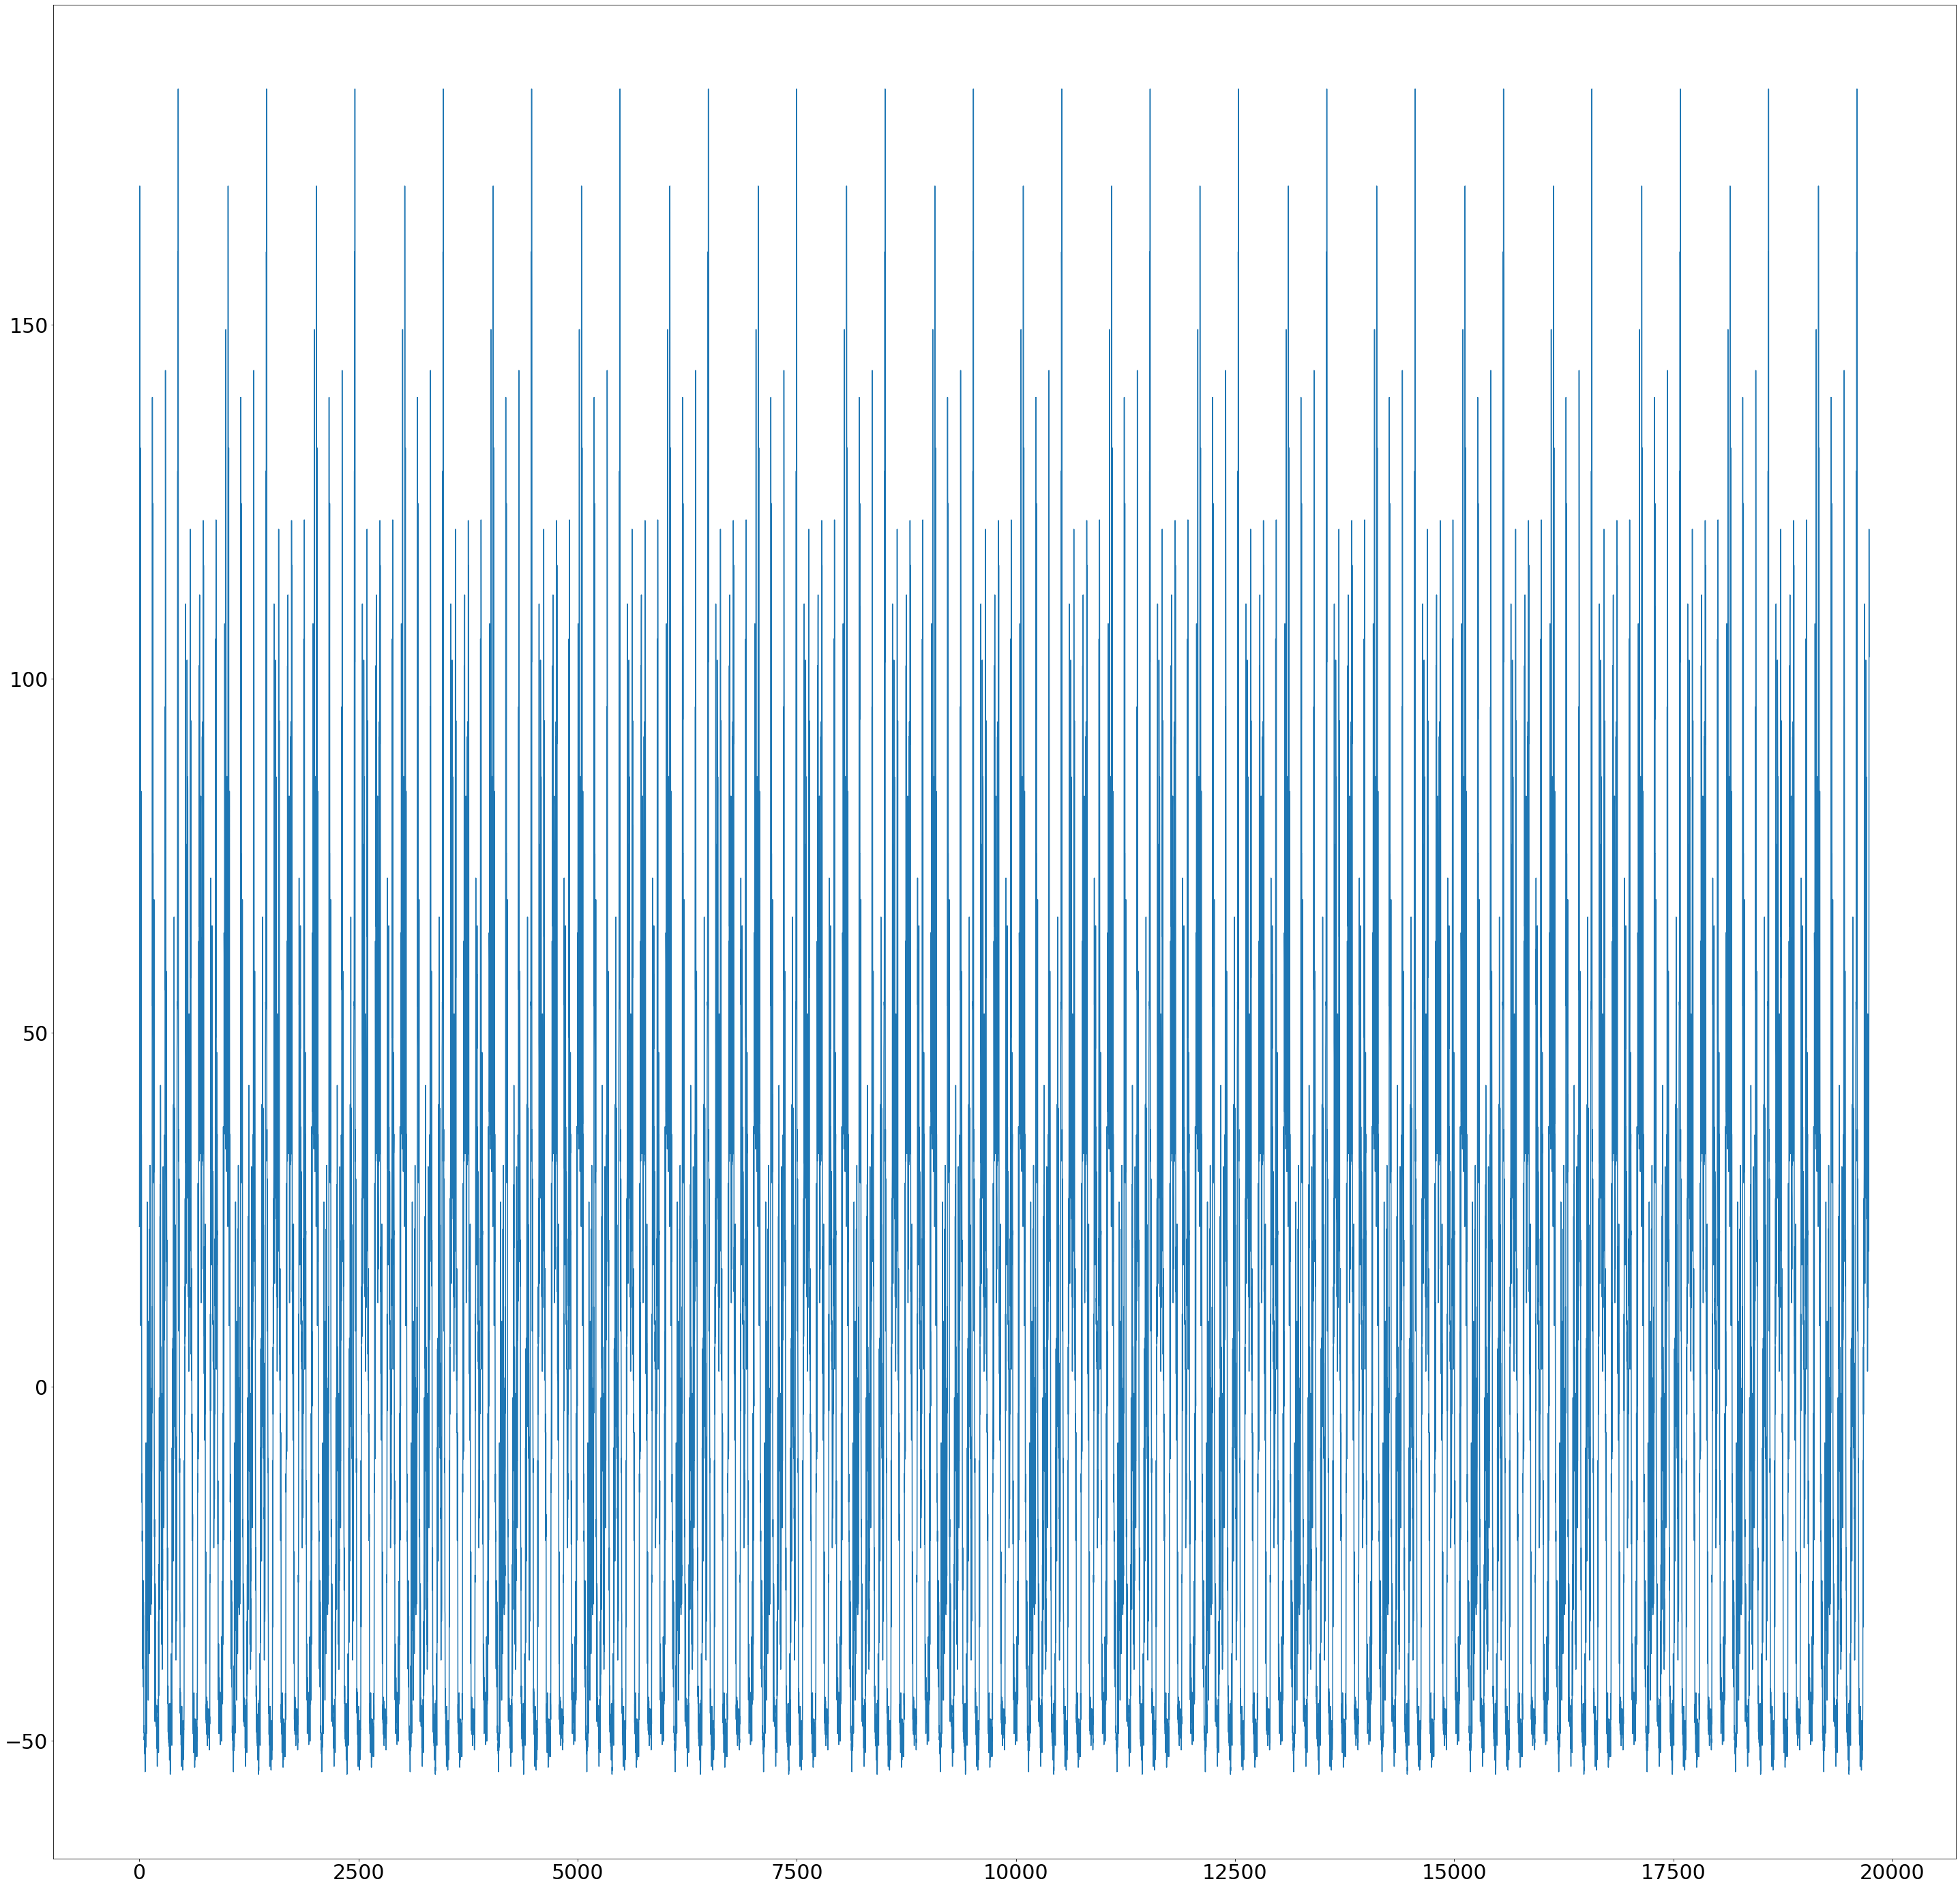

In [16]:
plt.figure(figsize=(50,50)) 
plt.plot(decomposition.seasonal)
plt.show()

# Plot of the seasonal component in the decomposed sequence

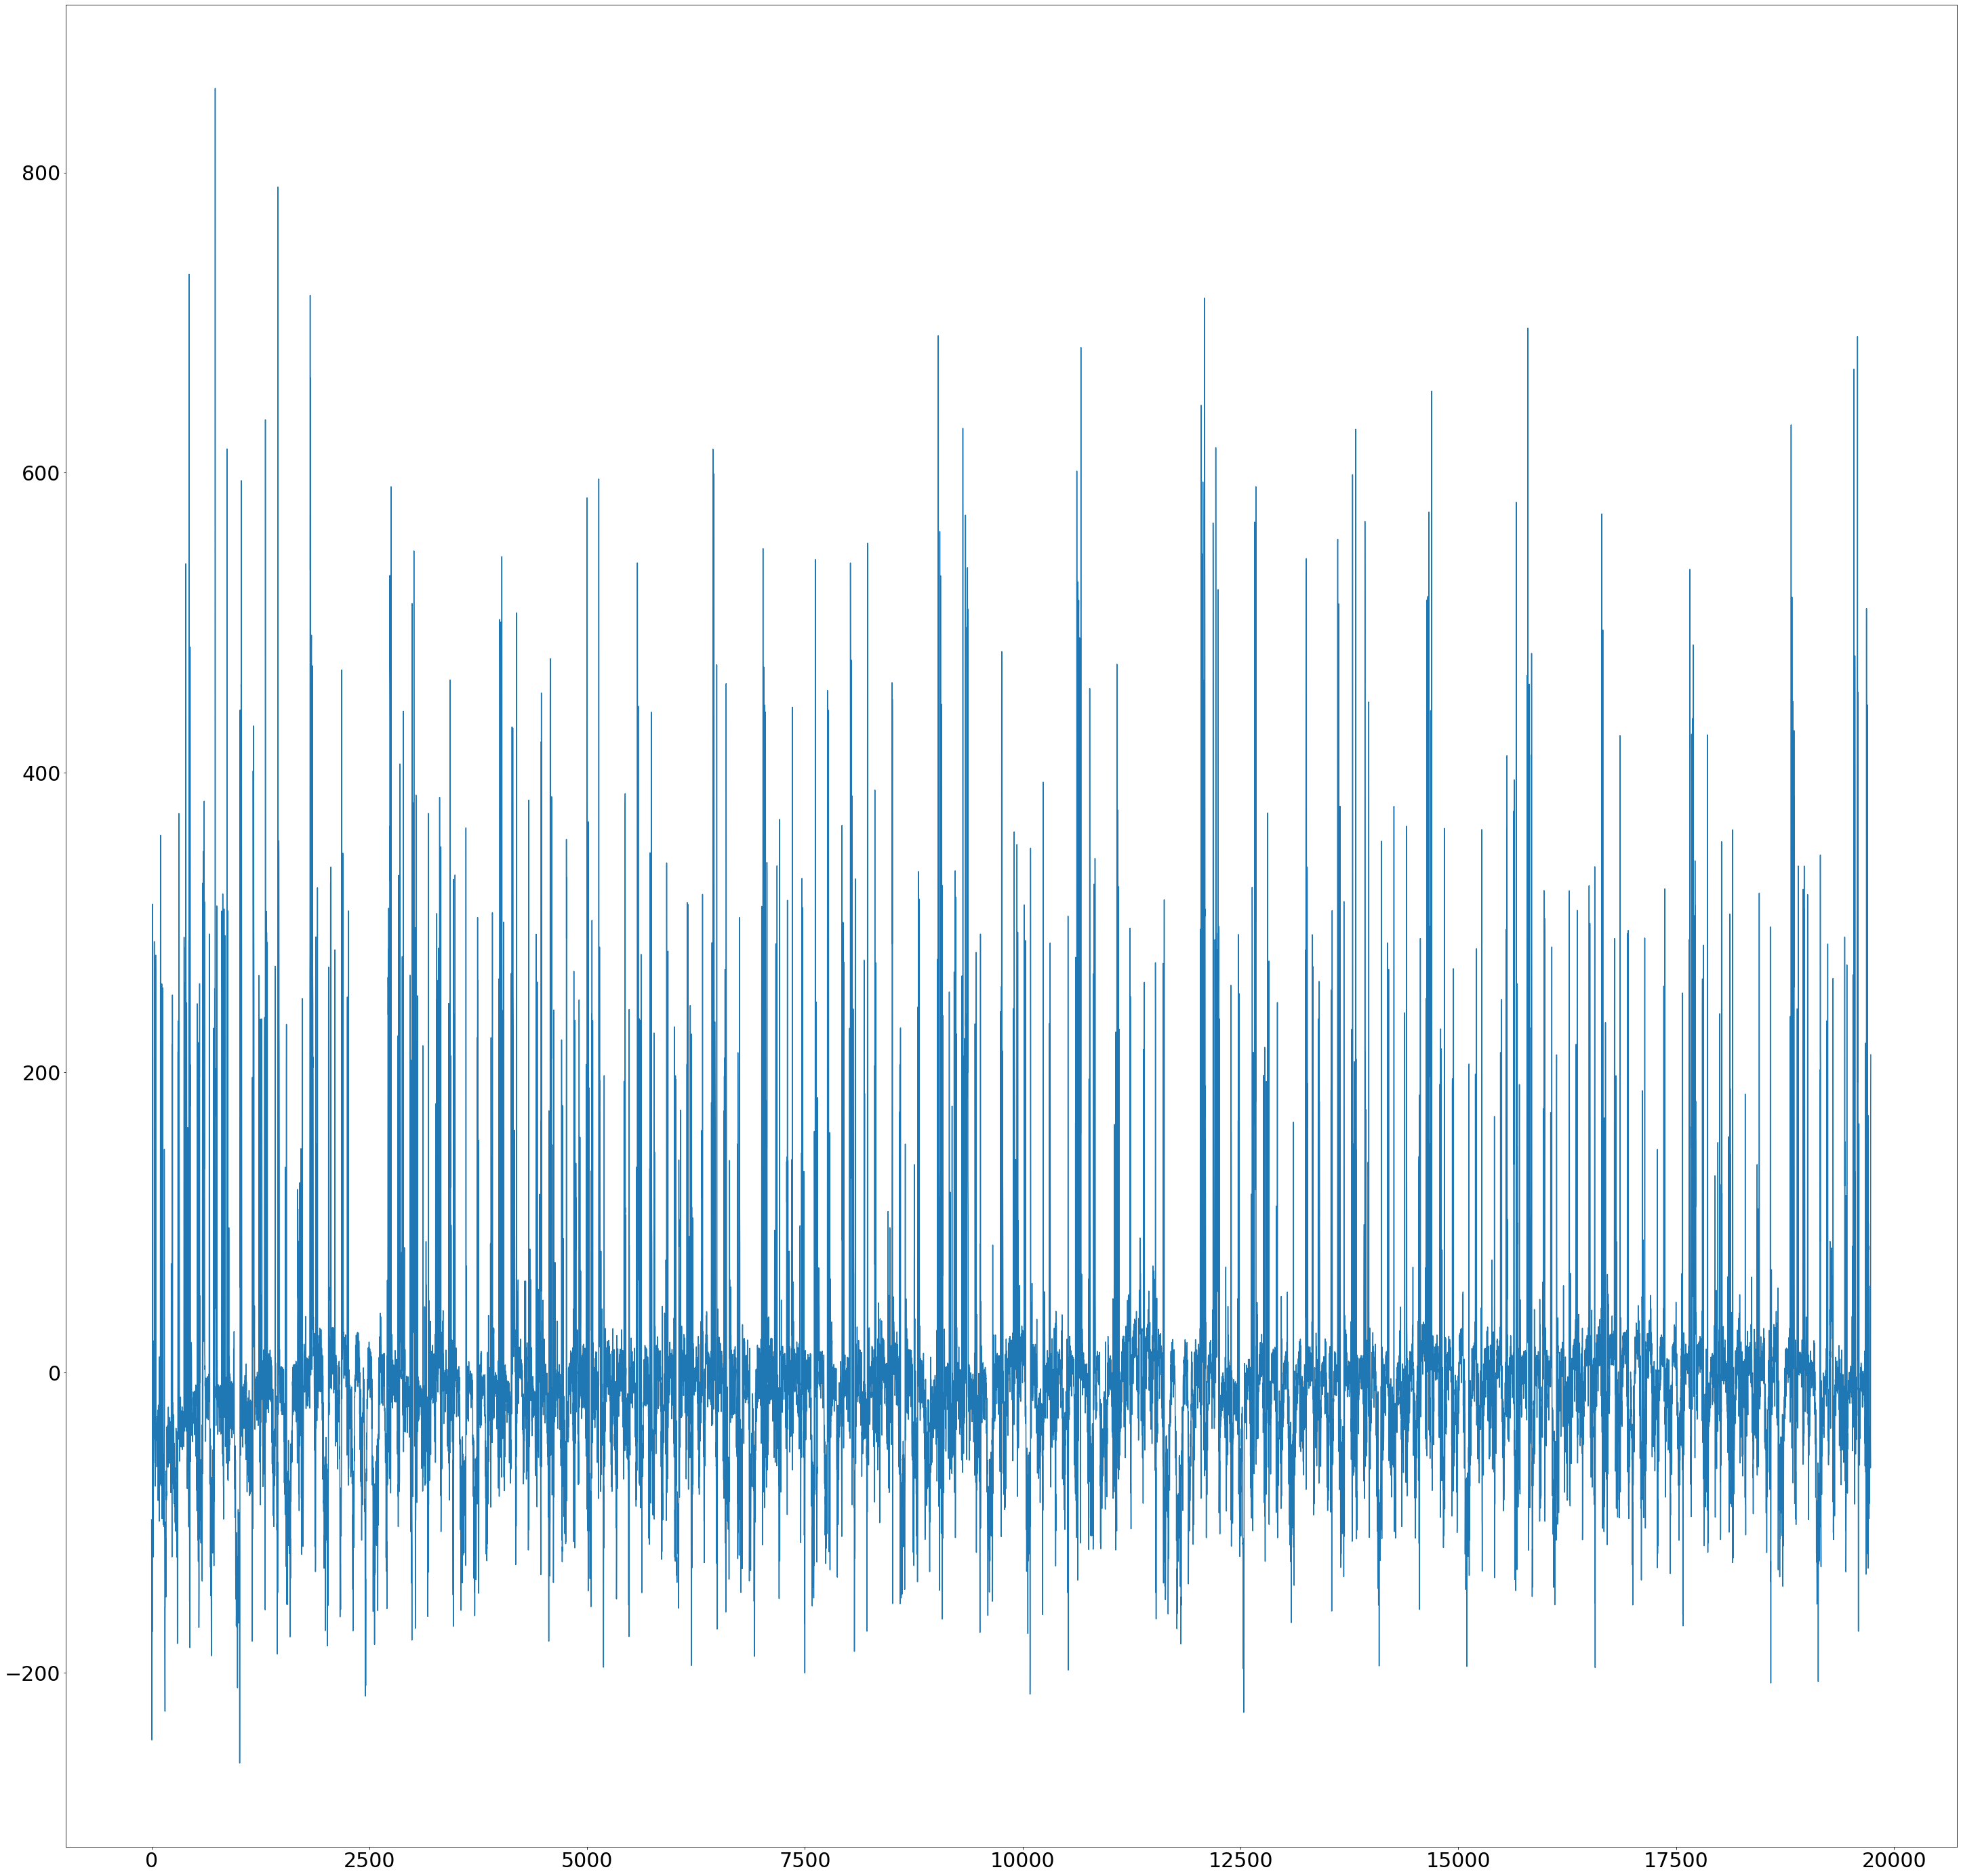

In [17]:
plt.figure(figsize=(50,50))
plt.plot(decomposition.resid)
plt.show()

# Plot of the noise in the decomposed sequence

Seeing the trend curve from the decomposition (in the example above i used 'additive' method but the same happends with 'multiplicative'), we can see that the serie has not a trend. Even more, the decomposition doesn't do a good work, the error is greater than the seasonal part, so we can say that there isn't a realy seasonal component, at least a linear one and with the maxima of the acf that i have found.

---

In the following, i learnt a linear regressor to the entire sequence, and then i subtract it from the sequence.

In [4]:
def linear_regressor_fit(sequence):

  X = np.array(range(sequence.size))
  X = np.reshape(X, (len(X), 1))
  y = sequence

  model = LinearRegression()
  _ = model.fit(X, y)

  a = model.coef_[0]
  b = model.intercept_

  return a, b

In [5]:
appliances_a, appliances_b = linear_regressor_fit(appliances_sequence)

print(f"Learned a: {appliances_a}")
print(f"Learned b: {appliances_b}")

Learned a: -0.0001733003056022034
Learned b: 99.40491231147524


In [6]:
print(f"Mean of the sequence: {np.mean(appliances_sequence)}")

Mean of the sequence: 97.6949581960983


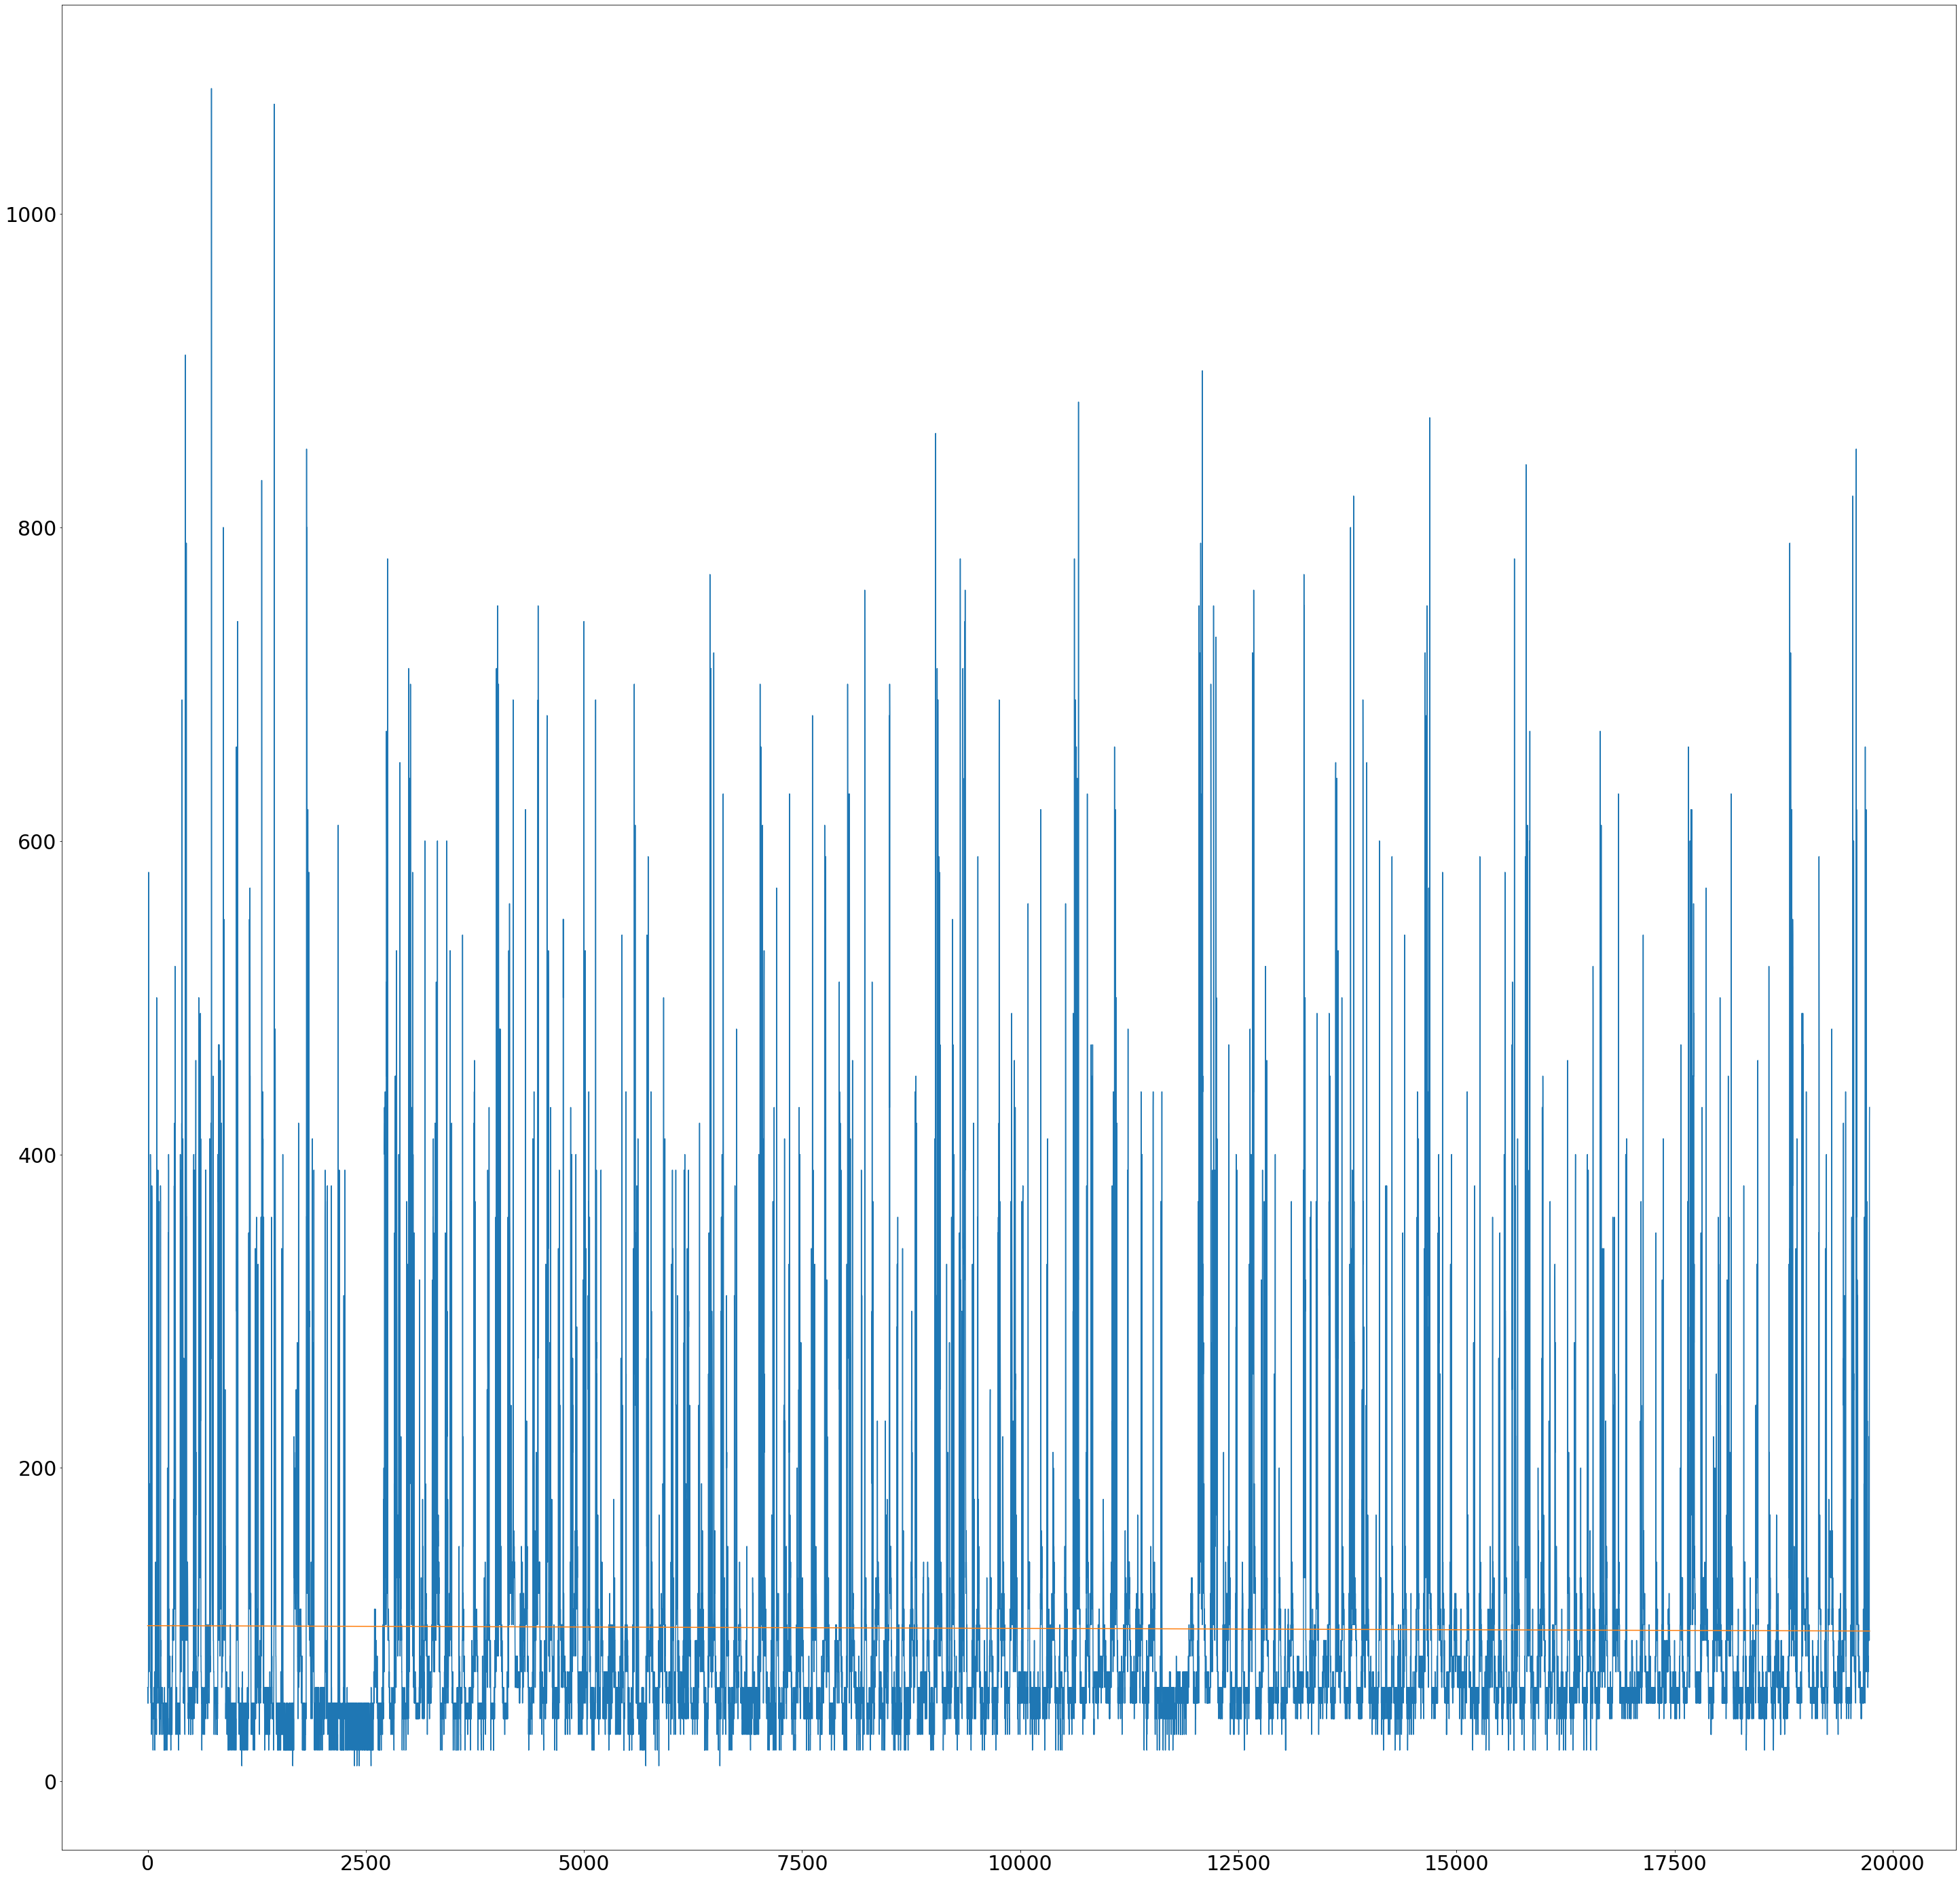

In [21]:
plt.figure(figsize=(50, 50))
plt.plot(appliances_sequence)
plt.plot([0, appliances_sequence.size], [appliances_b, appliances_sequence.size*appliances_a + appliances_b], linewidth=2)
plt.show()

# Plot of the appliances sequence and the linear model (red line) that best fit it

We can see that the a coefficient of the line that best fit the sequence is 0, so the sequence has no linear trend.

Anyway, I removed the line that fit the sequence to have the similar scale of the second sequence that I'll construct later.

In [7]:
detrended_sequence_1 = np.array([x_t - (t*appliances_a + appliances_b) for t, x_t in enumerate(appliances_sequence)])

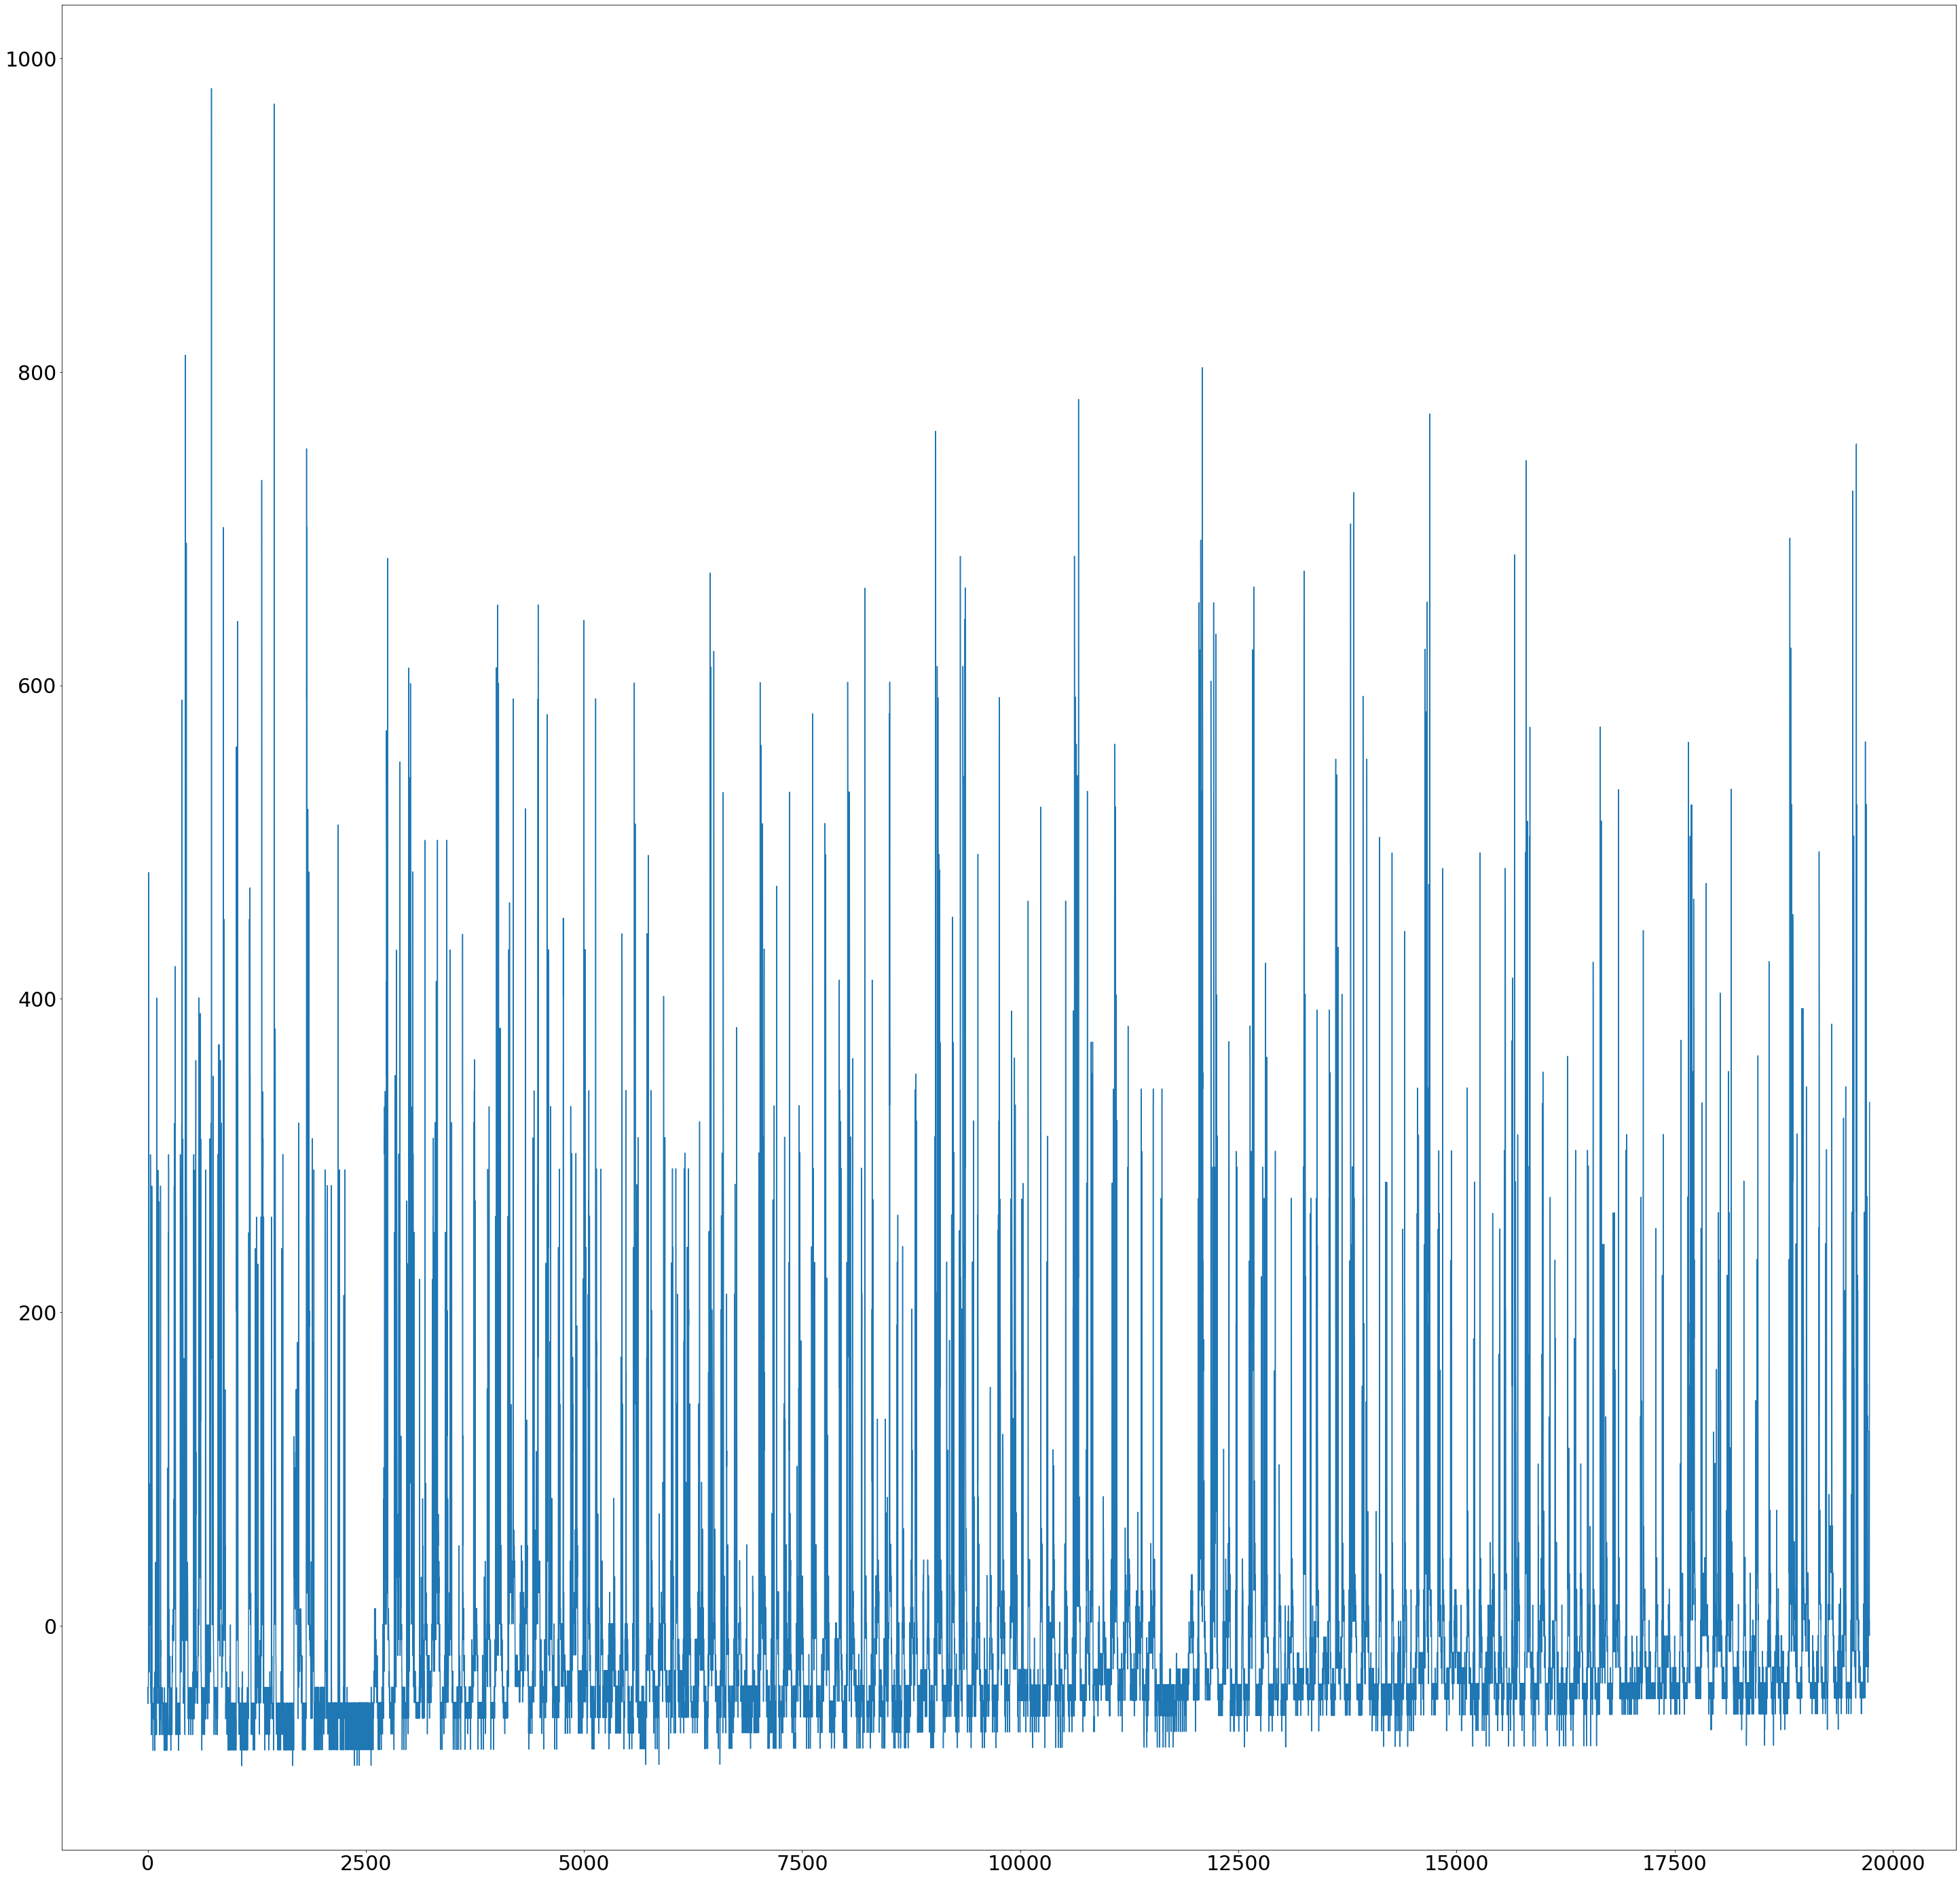

In [21]:
plt.figure(figsize=(50,50))
plt.plot(detrended_sequence_1)
plt.show()

# Plot of the appliances sequence without the linear trend

## Add trend to the sequence

Now since we have studied the trend of the sequence and now we have a sequence without any kind of linear trend, we can add a linear one to create the second sequence.

In [22]:
# define casual coefficients to form a linear model to add to detrended sequence
trend_a = 0.005
trend_b = 100

trended_sequence = np.array([x_t + trend_a*t + trend_b for (t,x_t) in enumerate(detrended_sequence_1)])

In [9]:
print(f"Mean of the sequence: {np.mean(trended_sequence)}")

Mean of the sequence: 149.335


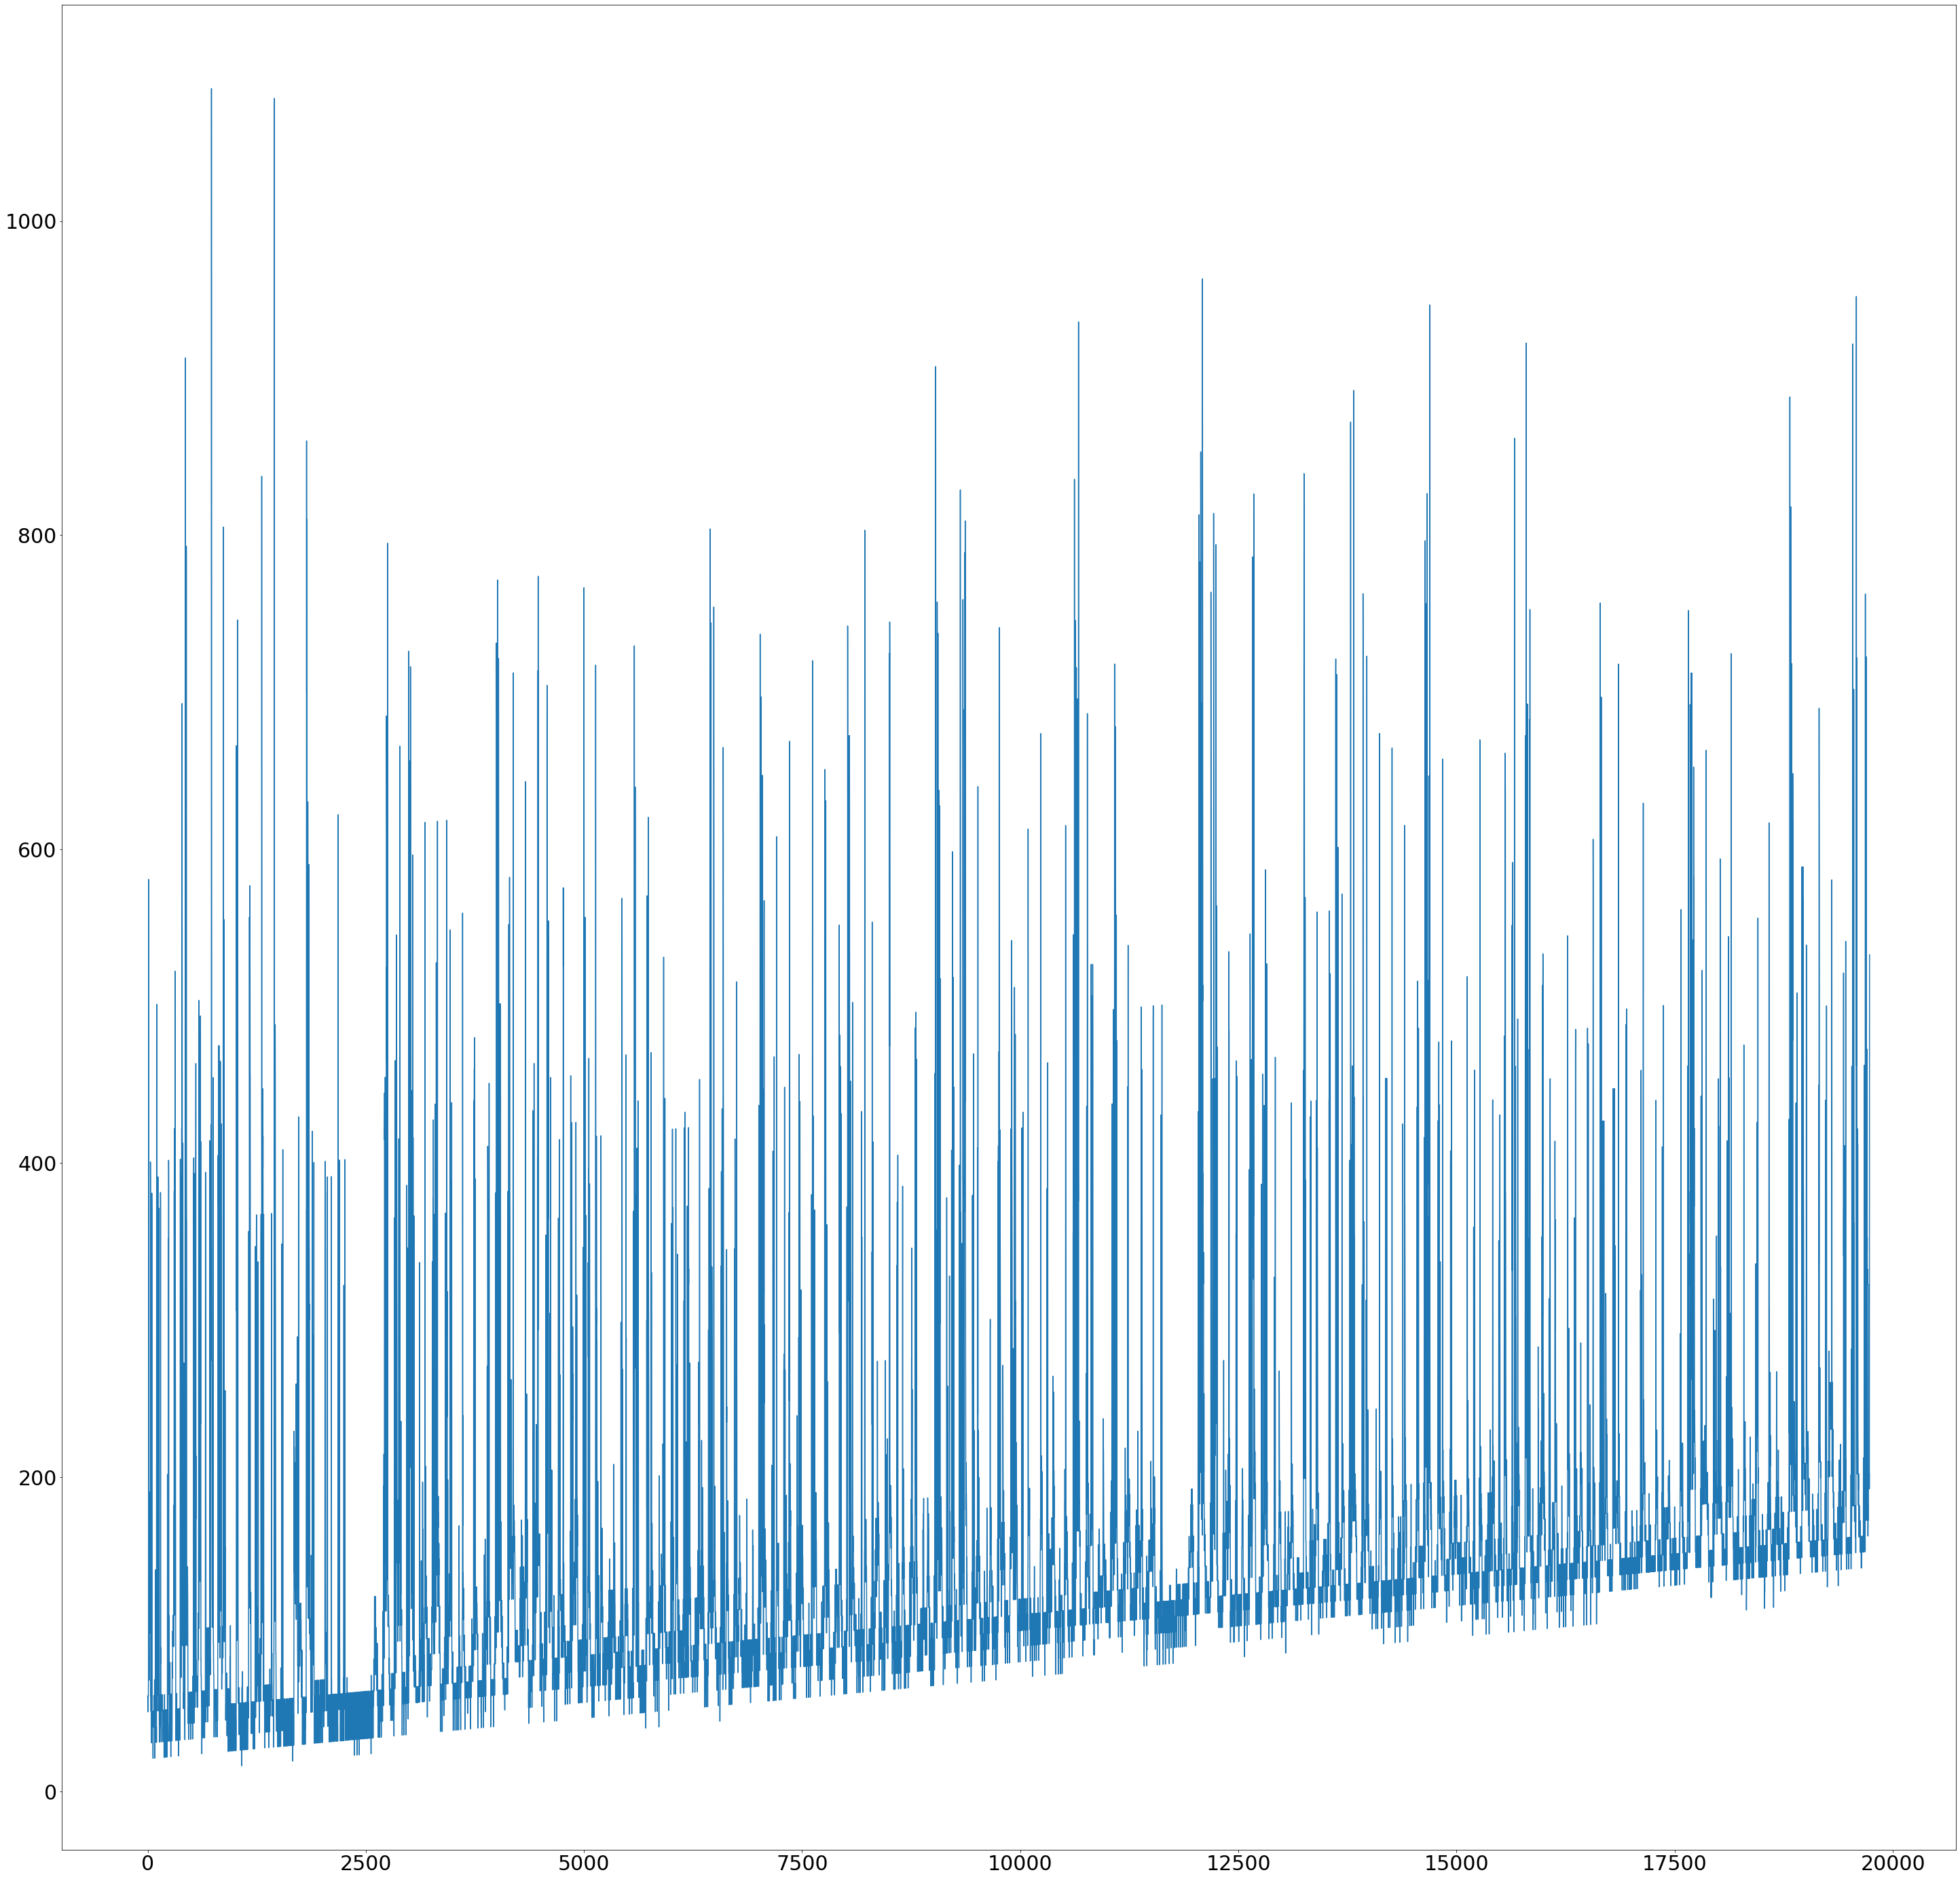

In [23]:
plt.figure(figsize=(50,50))
plt.plot(trended_sequence)
plt.show()

# Plot of the trended sequence

## Autoregressive analysis

The sequence represent the measurament of 4.5 months, we have to use 3 months to learn and the remaining to asses the models learned.

In [15]:
month_dim = int(appliances_sequence.size//(4.5))

three_months = month_dim*3

The learn_ARIMA function contain the core of the notebook, this function take a time serie (*sequence*), and aims to apply and evaluate an ARIMA model over it, taking a *patiente* and *sensitive* parameters that are usefull to avoid computational intensive operations.
The function learn an ARIMA model withe the *arima_params* parameters, over the [0:starting_point] slice of the *sequence*, and evaluate it over starting_point+1 point, the retrain the ARIMA model over the [1:starting_point+1] and evaluate it over starting_point+2 point, and so on, with this framework I noticed that the time required to learn over the entire sequence is very high, so I choose to reduce the number of the retrains, retraining only when the ARIMA model take a point that diverge (relative error) over *sensitive* valute for *patience* times consequently.
The learn_ARIMA function return the forecasted sequence (*forecasted_seq*), the sequence of relative errors (*relative_errors*), the vectors of the AR models learned over the sequence (*learned_AR_vectors*).

In [12]:
def learn_ARIMA(sequence, patience, sensitivity, starting_point, arima_params=(3,0,0)):
  """
  learns ARIMA model over the sequence and assess it throught the time.

  Args:
      sequence (np.array): A time serie.
      patience (int): The maximum number of contiguous missmatches btw forecast and real value before retraining
      sensitivity (int): The value that define missmatch, in relative error way.
      starting_point (int): The time for which start the assess phase.
      arima_params (tuple): The parameters passed to the ARIMA models.

  Returns:
      np.array: The forecasted sequence.
      np.array: The relative error btw the forecasted sequence and the real sequence.
      np.array: The learned AR vectors.
  """

  forecasted_seq = []
  relative_errors = []
  learned_AR_vectors = []
  retrains = 0

  # computational intensive !!!!
  # re-train the learner when the relative error of the forecasted value and the
  # true value become greater than some threshold for some number of iteration (patience)

  # idea: compare and define statistics over the the angles of the 3-d vectors
  # generated by the AR training

  remained_patience = patience

  i = 0
  for t in tqdm(range(starting_point, sequence.size-1)):
    if remained_patience <= 0 or i == 0:
      arma_model = ARIMA(sequence[:t], order=arima_params)
      res = arma_model.fit()
      learned_AR_vectors.append(res.polynomial_ar)
      remained_patience = patience
      retrains += 1

    forecasted = res.forecast(1)
    forecasted_seq.append(forecasted)
    real_to_forecast = sequence[t+1]
    relative_error = abs(real_to_forecast - forecasted)/abs(real_to_forecast)
    relative_errors.append(relative_error)

    if relative_error > sensitivity:
      remained_patience -= 1
    else:
      remained_patience = patience

    i+=1

  print("\n\nRetrains needed: ", retrains)

  return np.array(forecasted_seq).flatten(), np.array(relative_errors), np.array(learned_AR_vectors)

The following function is needed to compute a kind of similiarity between the AR models learned by the learn_ARIMA process, from the slide of the course, with the AR vectors learned i can compare two time series use any kind of distance.
In this case with the AR vectors I can see how much the learned AR models diverge to each other during the process, I see how they diverge from their euclidean centroid, computing the mean distance and the standard deviation of the distances.

In [11]:
def AR_vectors_statistics(AR_vectors):
  """
    Compute the divergence of some vectors to each others.
    It's supposed that those vectors are computed as AR parameters.

    Args:
        AR_vectors (np.array): The AR vectors.

    Returns:
        np.float64: The mean of the distances of the vectors w.r.t their centroid.
        np.float64: The standard deviation of the distances of the vectors w.r.t their centroid.
    """

  # euclidean centroid of the AR learned vectors
  centroid_AR_vector = np.mean(AR_vectors, axis=0)

  euclidean_distances_centroid = np.linalg.norm(AR_vectors - centroid_AR_vector, axis=1)

  mean_distances = np.mean(euclidean_distances_centroid)

  std_distances = np.std(euclidean_distances_centroid)

  return mean_distances, std_distances

In [10]:
def MSE(original_seq, forecasted_seq):
  """
  Utility function to compute Mean Squared Error

  Args:
      original_seq (np.array): A time serie.
      forecasted_seq (np.array): Another time serie, it's lenght has to be equal to the previous one. 

  Returns:
      np.float64: MSE btw original_seq and forecasted_seq.
  """

  return (np.linalg.norm(original_seq - forecasted_seq)**2)/len(forecasted_seq)

### De-trended sequence

Cicle t over the last 1.5 months computing error of the t+1 element forecasted by the ARMA model learned on the data until t.

I choose to learn a AR model with Q = 3, because i see that AR with Q > 3 and ARMA models take a lot of time to be executed even i change the patience and sensitivy parameters.

In [33]:
print("Some statistics over the First detrended sequence")
print(f"Mean of the sequence: {np.mean(detrended_sequence_1)}")
print(f"Min of the sequence: {np.min(detrended_sequence_1)}")
print(f"Max of the sequence: {np.max(detrended_sequence_1)}")

Some statistics over the First detrended sequence
Mean of the sequence: 9.217073238134566e-16
Min of the sequence: -89.21792128173047
Max of the sequence: 980.72177021192


In [35]:
forecasted_seq_1, relative_errors_1, learned_AR_vectors_1 = learn_ARIMA(detrended_sequence_1, 10, 0.5, three_months, (3,0,0))

100%|██████████| 6579/6579 [08:54<00:00, 12.31it/s]



Retrains needed:  168


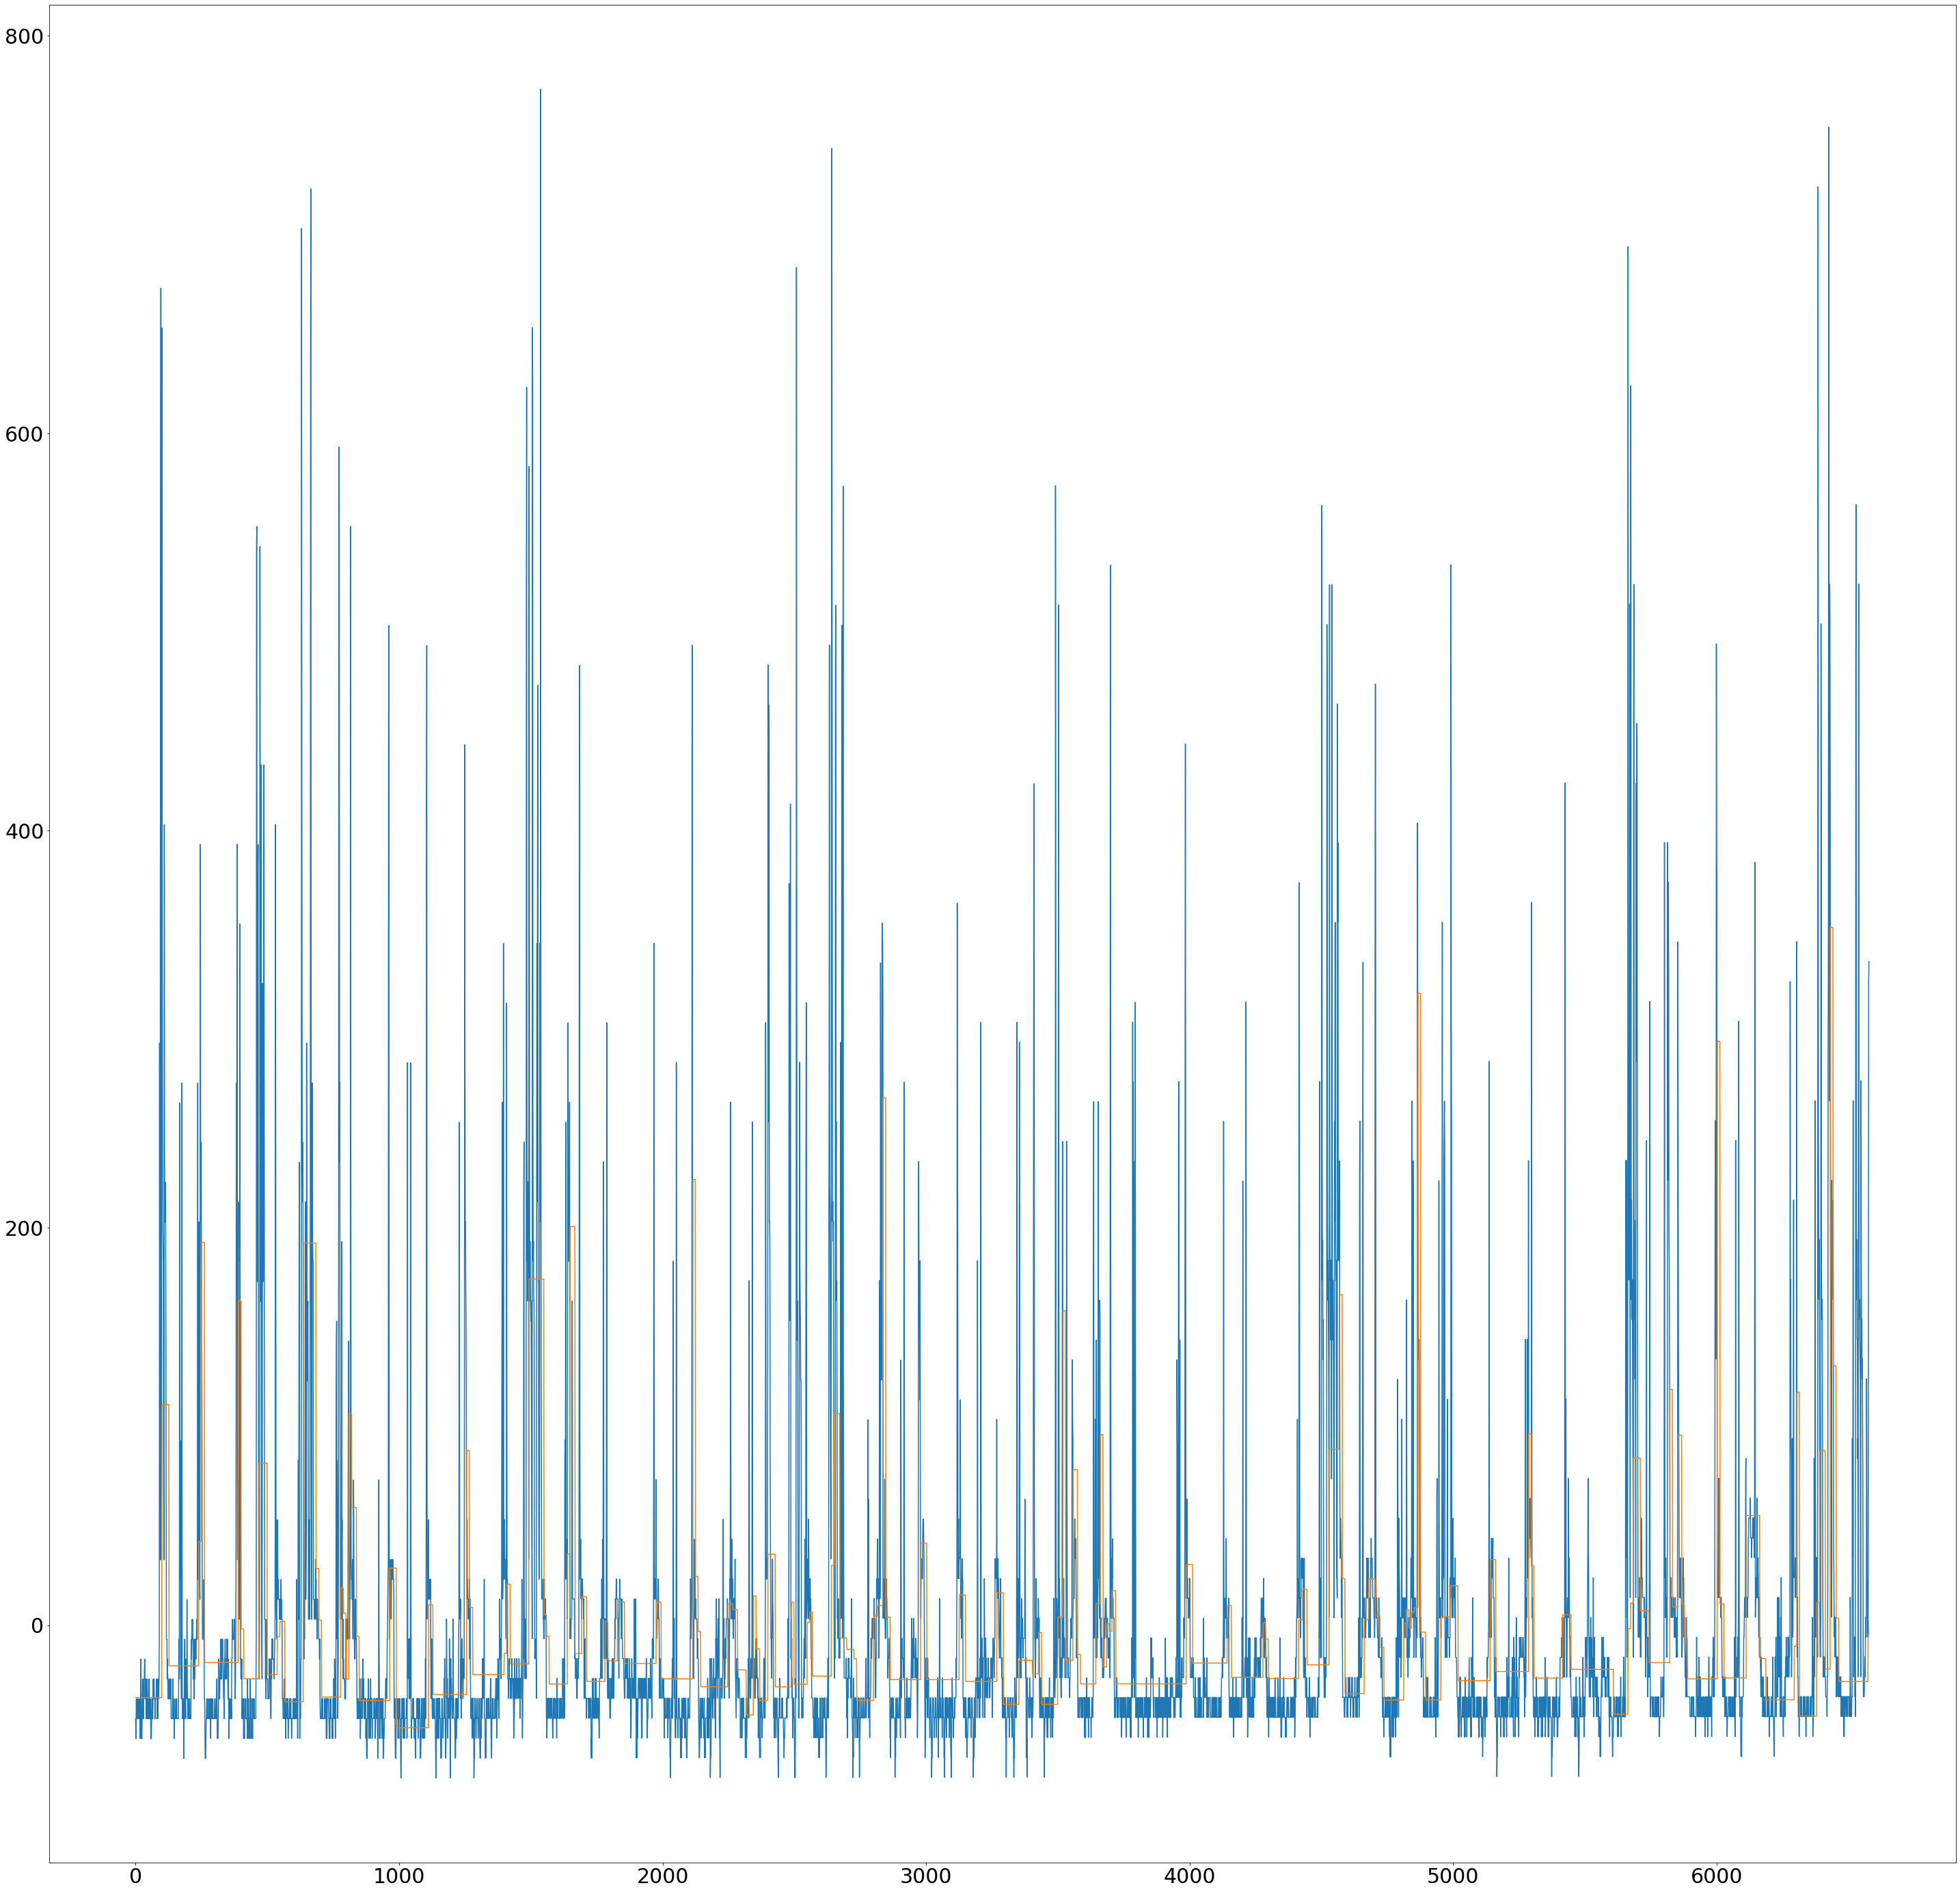

In [36]:
plt.figure(figsize=(50,50))
plt.plot(detrended_sequence_1[three_months+1:])
plt.plot(forecasted_seq_1)
plt.show()

# Plot of the forecasted sequence and the real part of the sequence over which i learned the ARIMA model

In [37]:
print(f"Relative errors over the predicted data, mean: {np.mean(relative_errors_1)}, standard deviation: {np.std(relative_errors_1)}")

Relative errors over the predicted data, mean: 1.6703388925528897, standard deviation: 5.332326665834398


In [38]:
MSE_1 = MSE(detrended_sequence_1[three_months+1:], forecasted_seq_1)

print("MSE of the forecasted sequence w.r.t. the last part of the sequence: ", MSE_1)

MSE of the forecasted sequence w.r.t. the last part of the sequence:  8643.379435881492


Showing the distance of the AR learned vector from their centroid (euclidean one), to see how the sequence, encoded by the AR vectors, change over time.

In [39]:
mean_distances_1, std_distances_1 = AR_vectors_statistics(learned_AR_vectors_1)
print(f"Mean distances of the AR vectors learned and their centroids: {mean_distances_1}")
print(f"Standard deviation of the distances of the AR vectors learned and their centroid: {std_distances_1}")

Mean distances of the AR vectors learned and their centroids: 0.008457449285473309
Standard deviation of the distances of the AR vectors learned and their centroid: 0.00405001348388399


We can see that, in the case of the first sequence, the mean and the standard deviation are relativelly small, so the AR models learned are quite similar throught the time.

## Trended sequence

For the second sequence, with the linear trend, we are not in the hypotesis of the weak stationarity, so have to remove the trend on the sequence.

In [40]:
def window_linear_trend(sequence, window):
  """
    Given a time serie and a window this function tries to learn a linear model 
    piece by piece (window dim) over the sequence.

    Args:
        sequence (np.array): A time serie.
        window (int): The dimension of the window in which compute the linear model

    Returns:
        np.array: the sequence of the learned trends
    """

  # removing the trend linearly piece by piece
  
  # cycle over the sequence window by window, learning linear trend
  learned_trend = np.array([])

  for i in range(0, sequence.size, window):

    window_a, window_b = linear_regressor_fit(sequence[i: i+window])

    # deal with last part if the sequence lenght isn't a multiple of window
    learned_size = window
    if i+window >= sequence.size:
      learned_size = sequence.size%window

    learned_trend = np.append(learned_trend, np.arange(0, learned_size)*window_a + window_b)

  return learned_trend

In [41]:
learned_trend = window_linear_trend(trended_sequence, week)

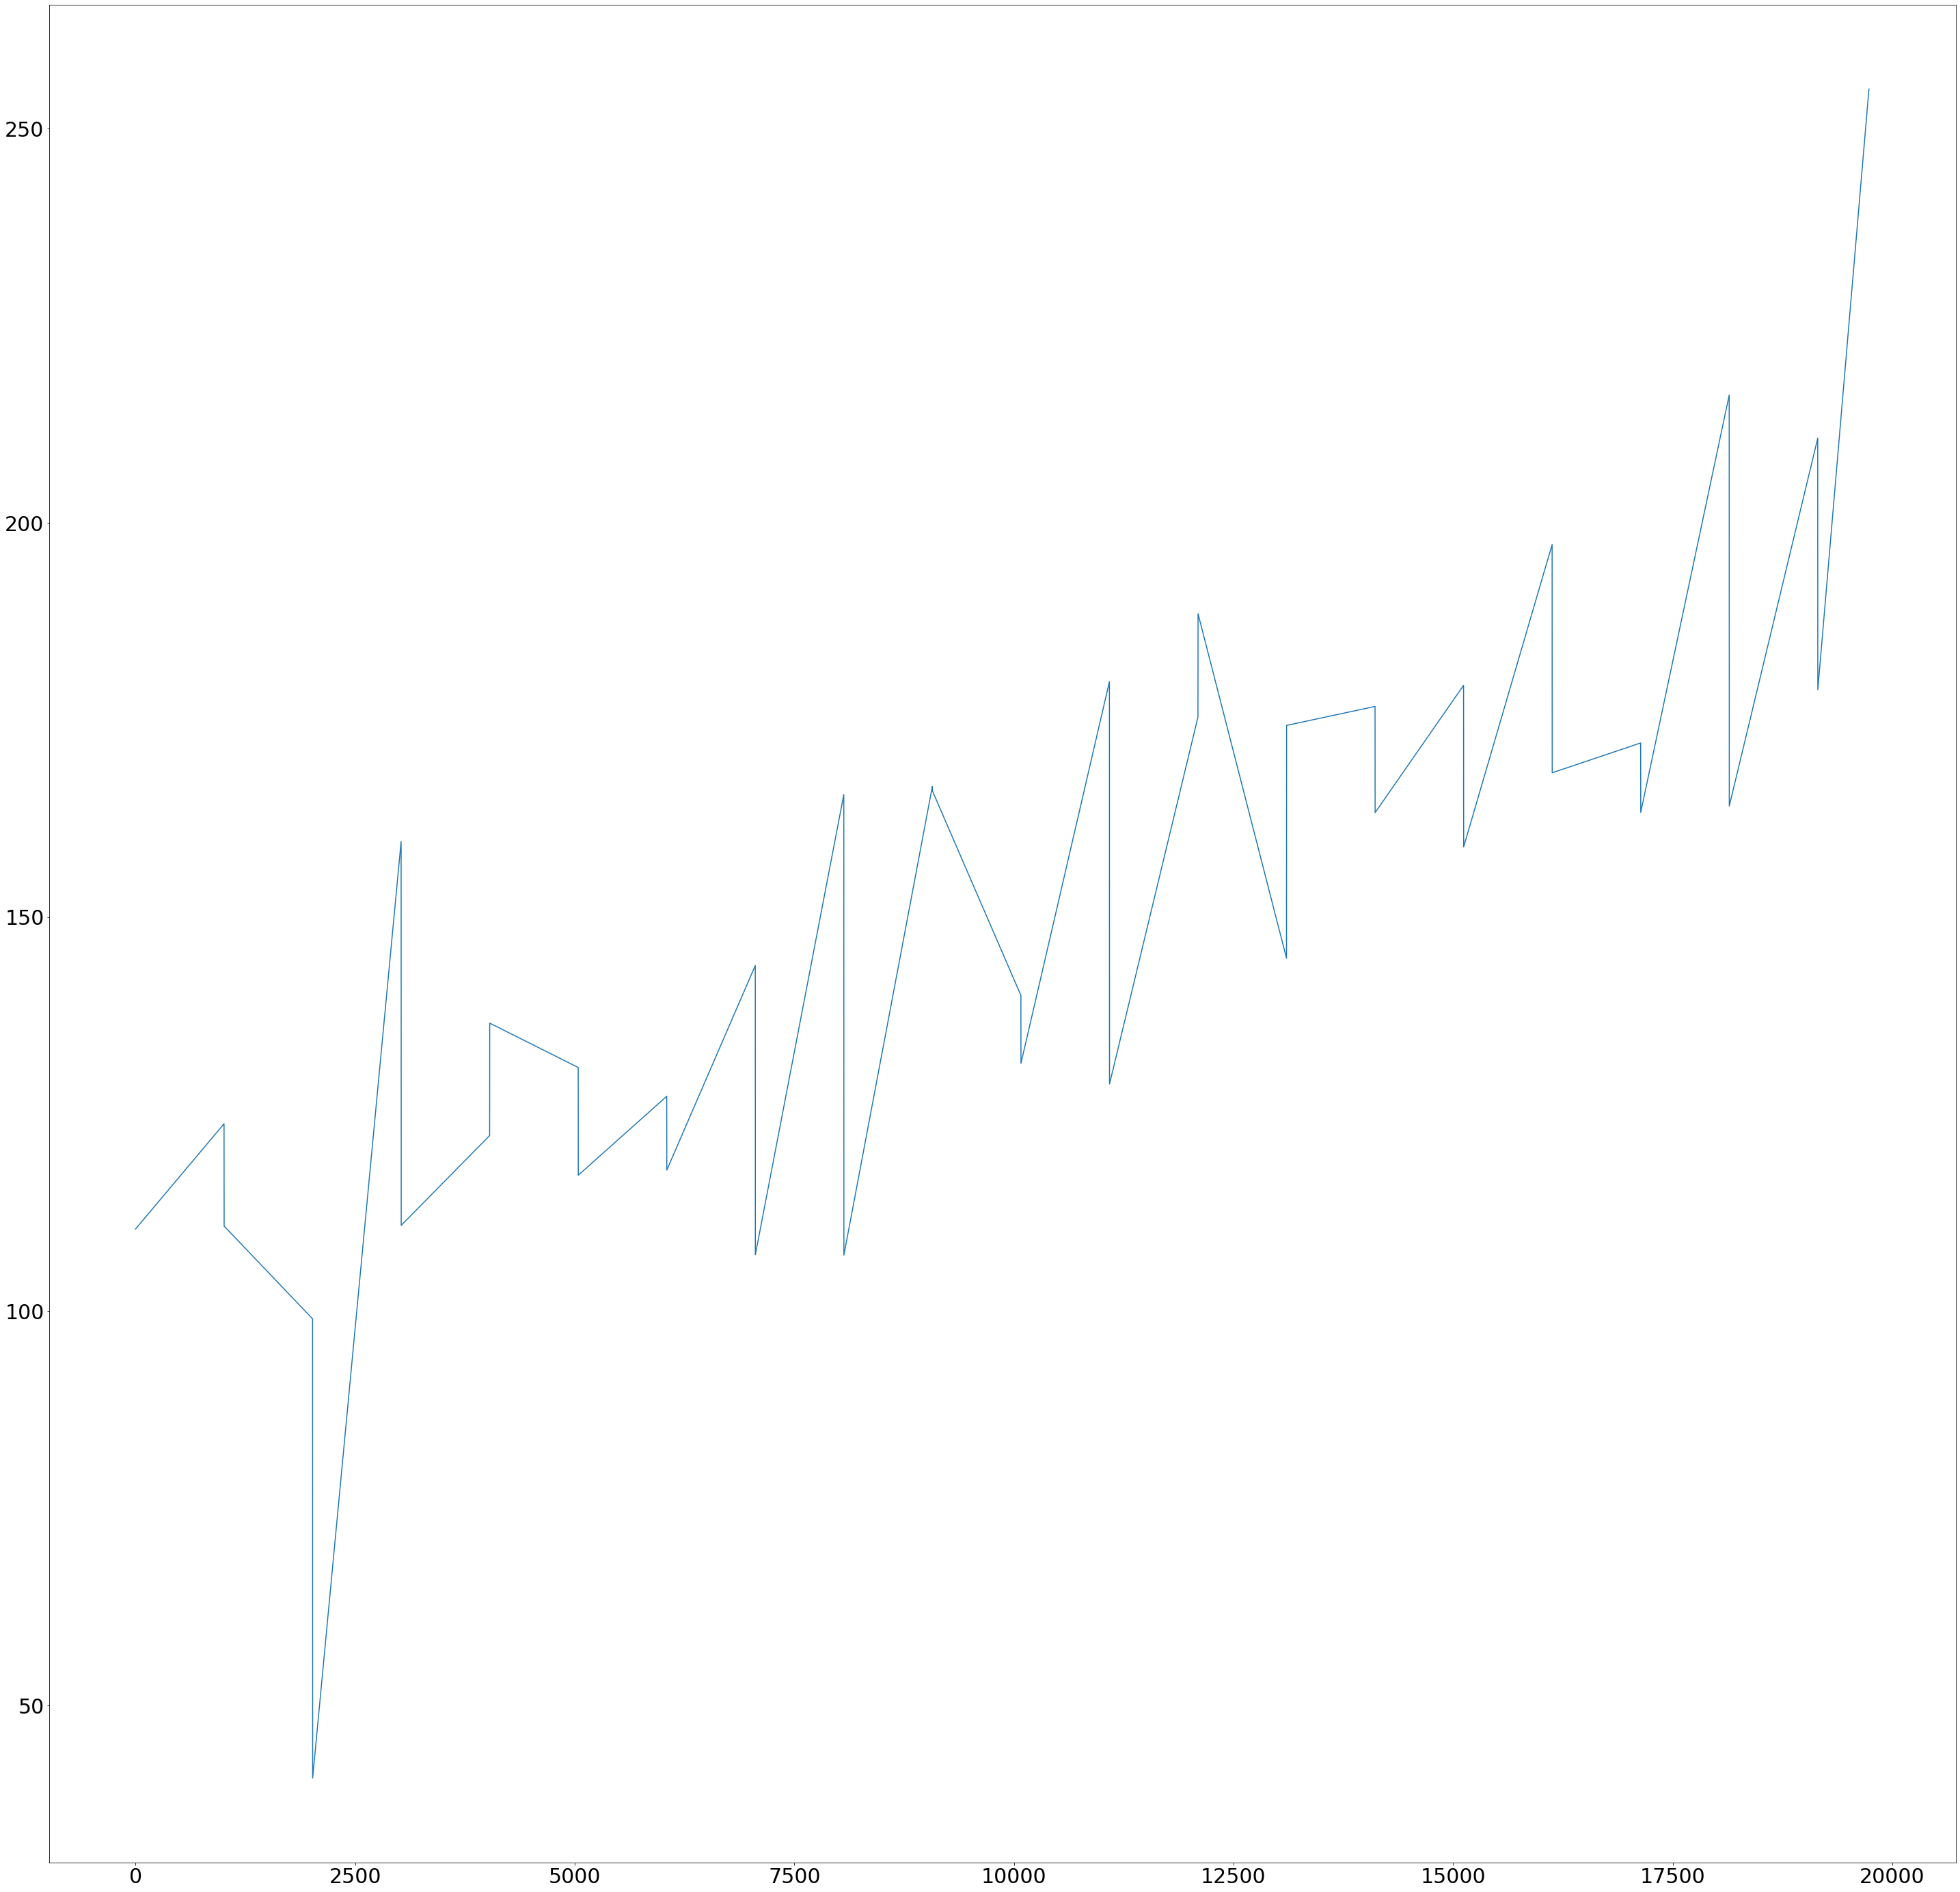

In [42]:
plt.figure(figsize=(50,50))
plt.plot(learned_trend)
plt.show()

# Plot of the Linear models learned window by window piece

In [43]:
detrended_sequence_2 = trended_sequence - learned_trend

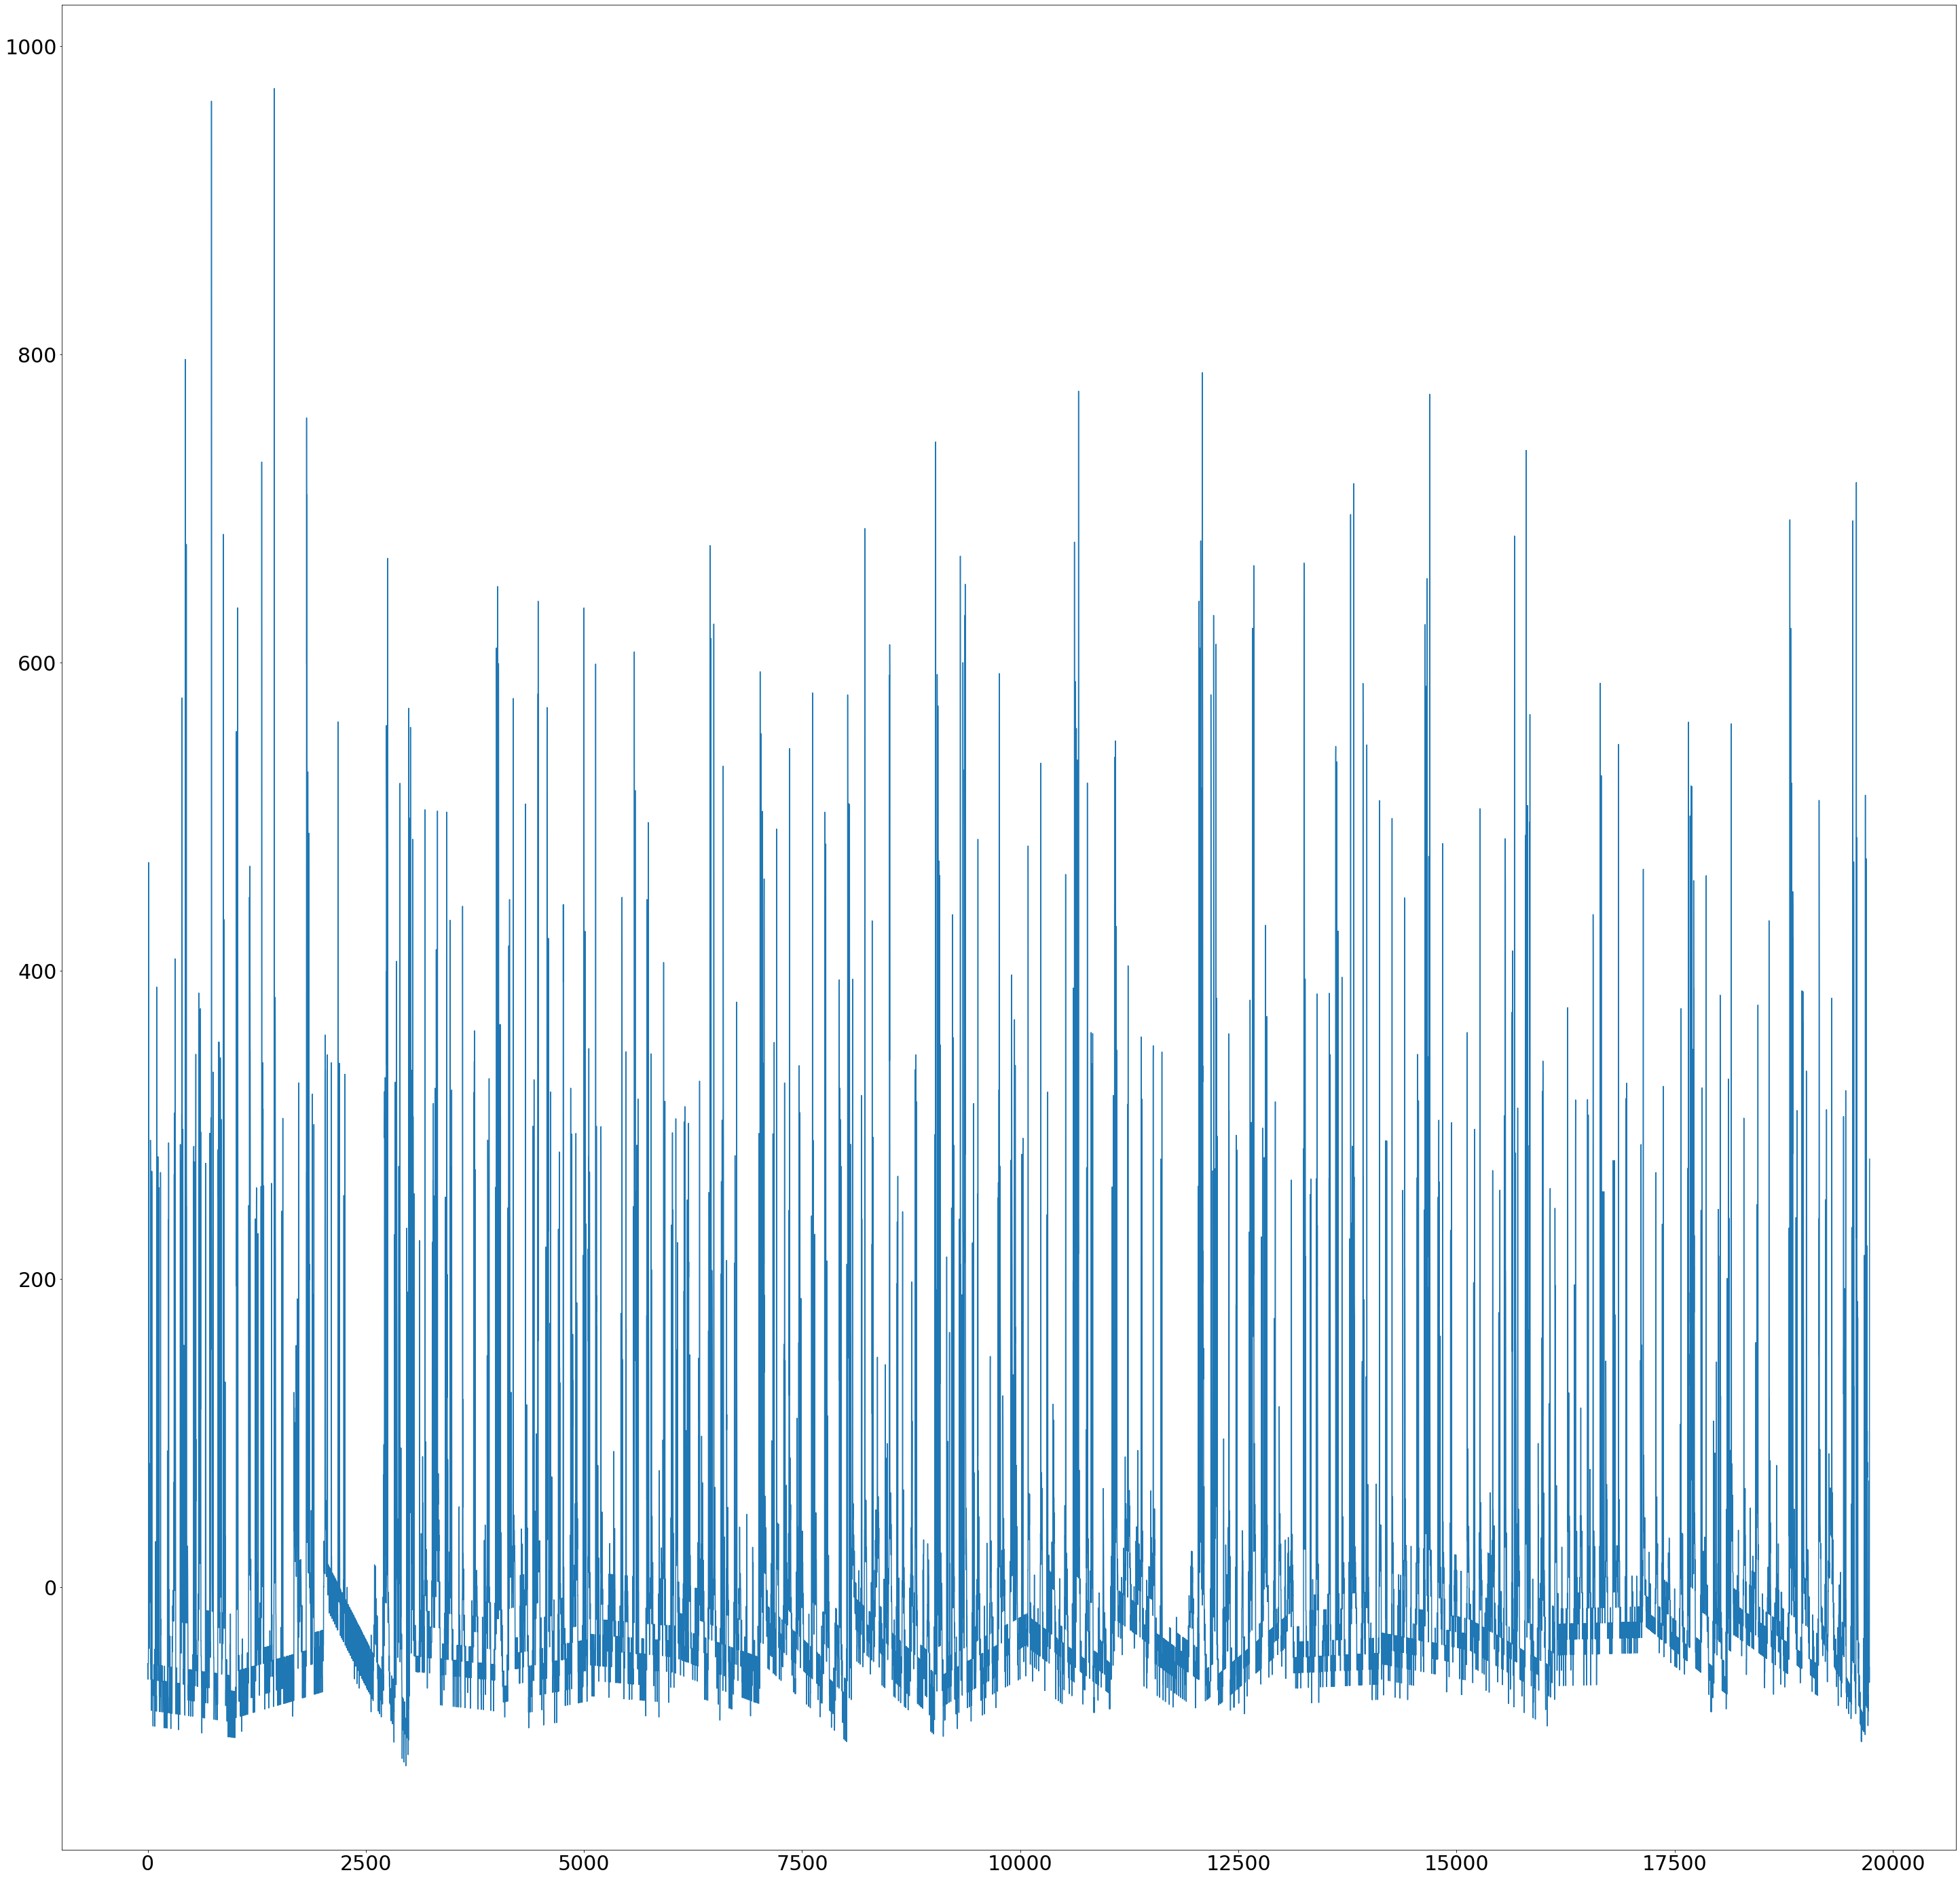

In [44]:
plt.figure(figsize=(50,50))
plt.plot(detrended_sequence_2)
plt.show()

# Plot of the detrended sequence with piece-wise linear model

In [45]:
detrended_2_a, detrended_2_b = linear_regressor_fit(detrended_sequence_2)

print(f"Learned a: {detrended_2_a}")
print(f"Learned b: {detrended_2_b}")

Learned a: -9.766024656786112e-19
Learned b: 8.391831641702691e-15


Now, since the sequence has no more the added linear trend we can learn the AR model on it as we have done for the un-trended sequence.

I used the same parameters as the learn_ARIMA execution above for the same motivations due to intensive computations needed.

In [46]:
print("Some statistics over the Second detrended sequence")
print(f"Mean of the sequence: {np.mean(detrended_sequence_2)}")
print(f"Min of the sequence: {np.min(detrended_sequence_2)}")
print(f"Max of the sequence: {np.max(detrended_sequence_2)}")

Some statistics over the Second detrended sequence
Mean of the sequence: -1.2443048871481663e-15
Min of the sequence: -116.10946936736161
Max of the sequence: 972.4823185215564


In [47]:
forecasted_seq_2, relative_errors_2, learned_AR_vectors_2 = learn_ARIMA(detrended_sequence_2, 10, 0.5, three_months, (3,0,0))

100%|██████████| 6579/6579 [08:37<00:00, 12.71it/s]



Retrains needed:  170


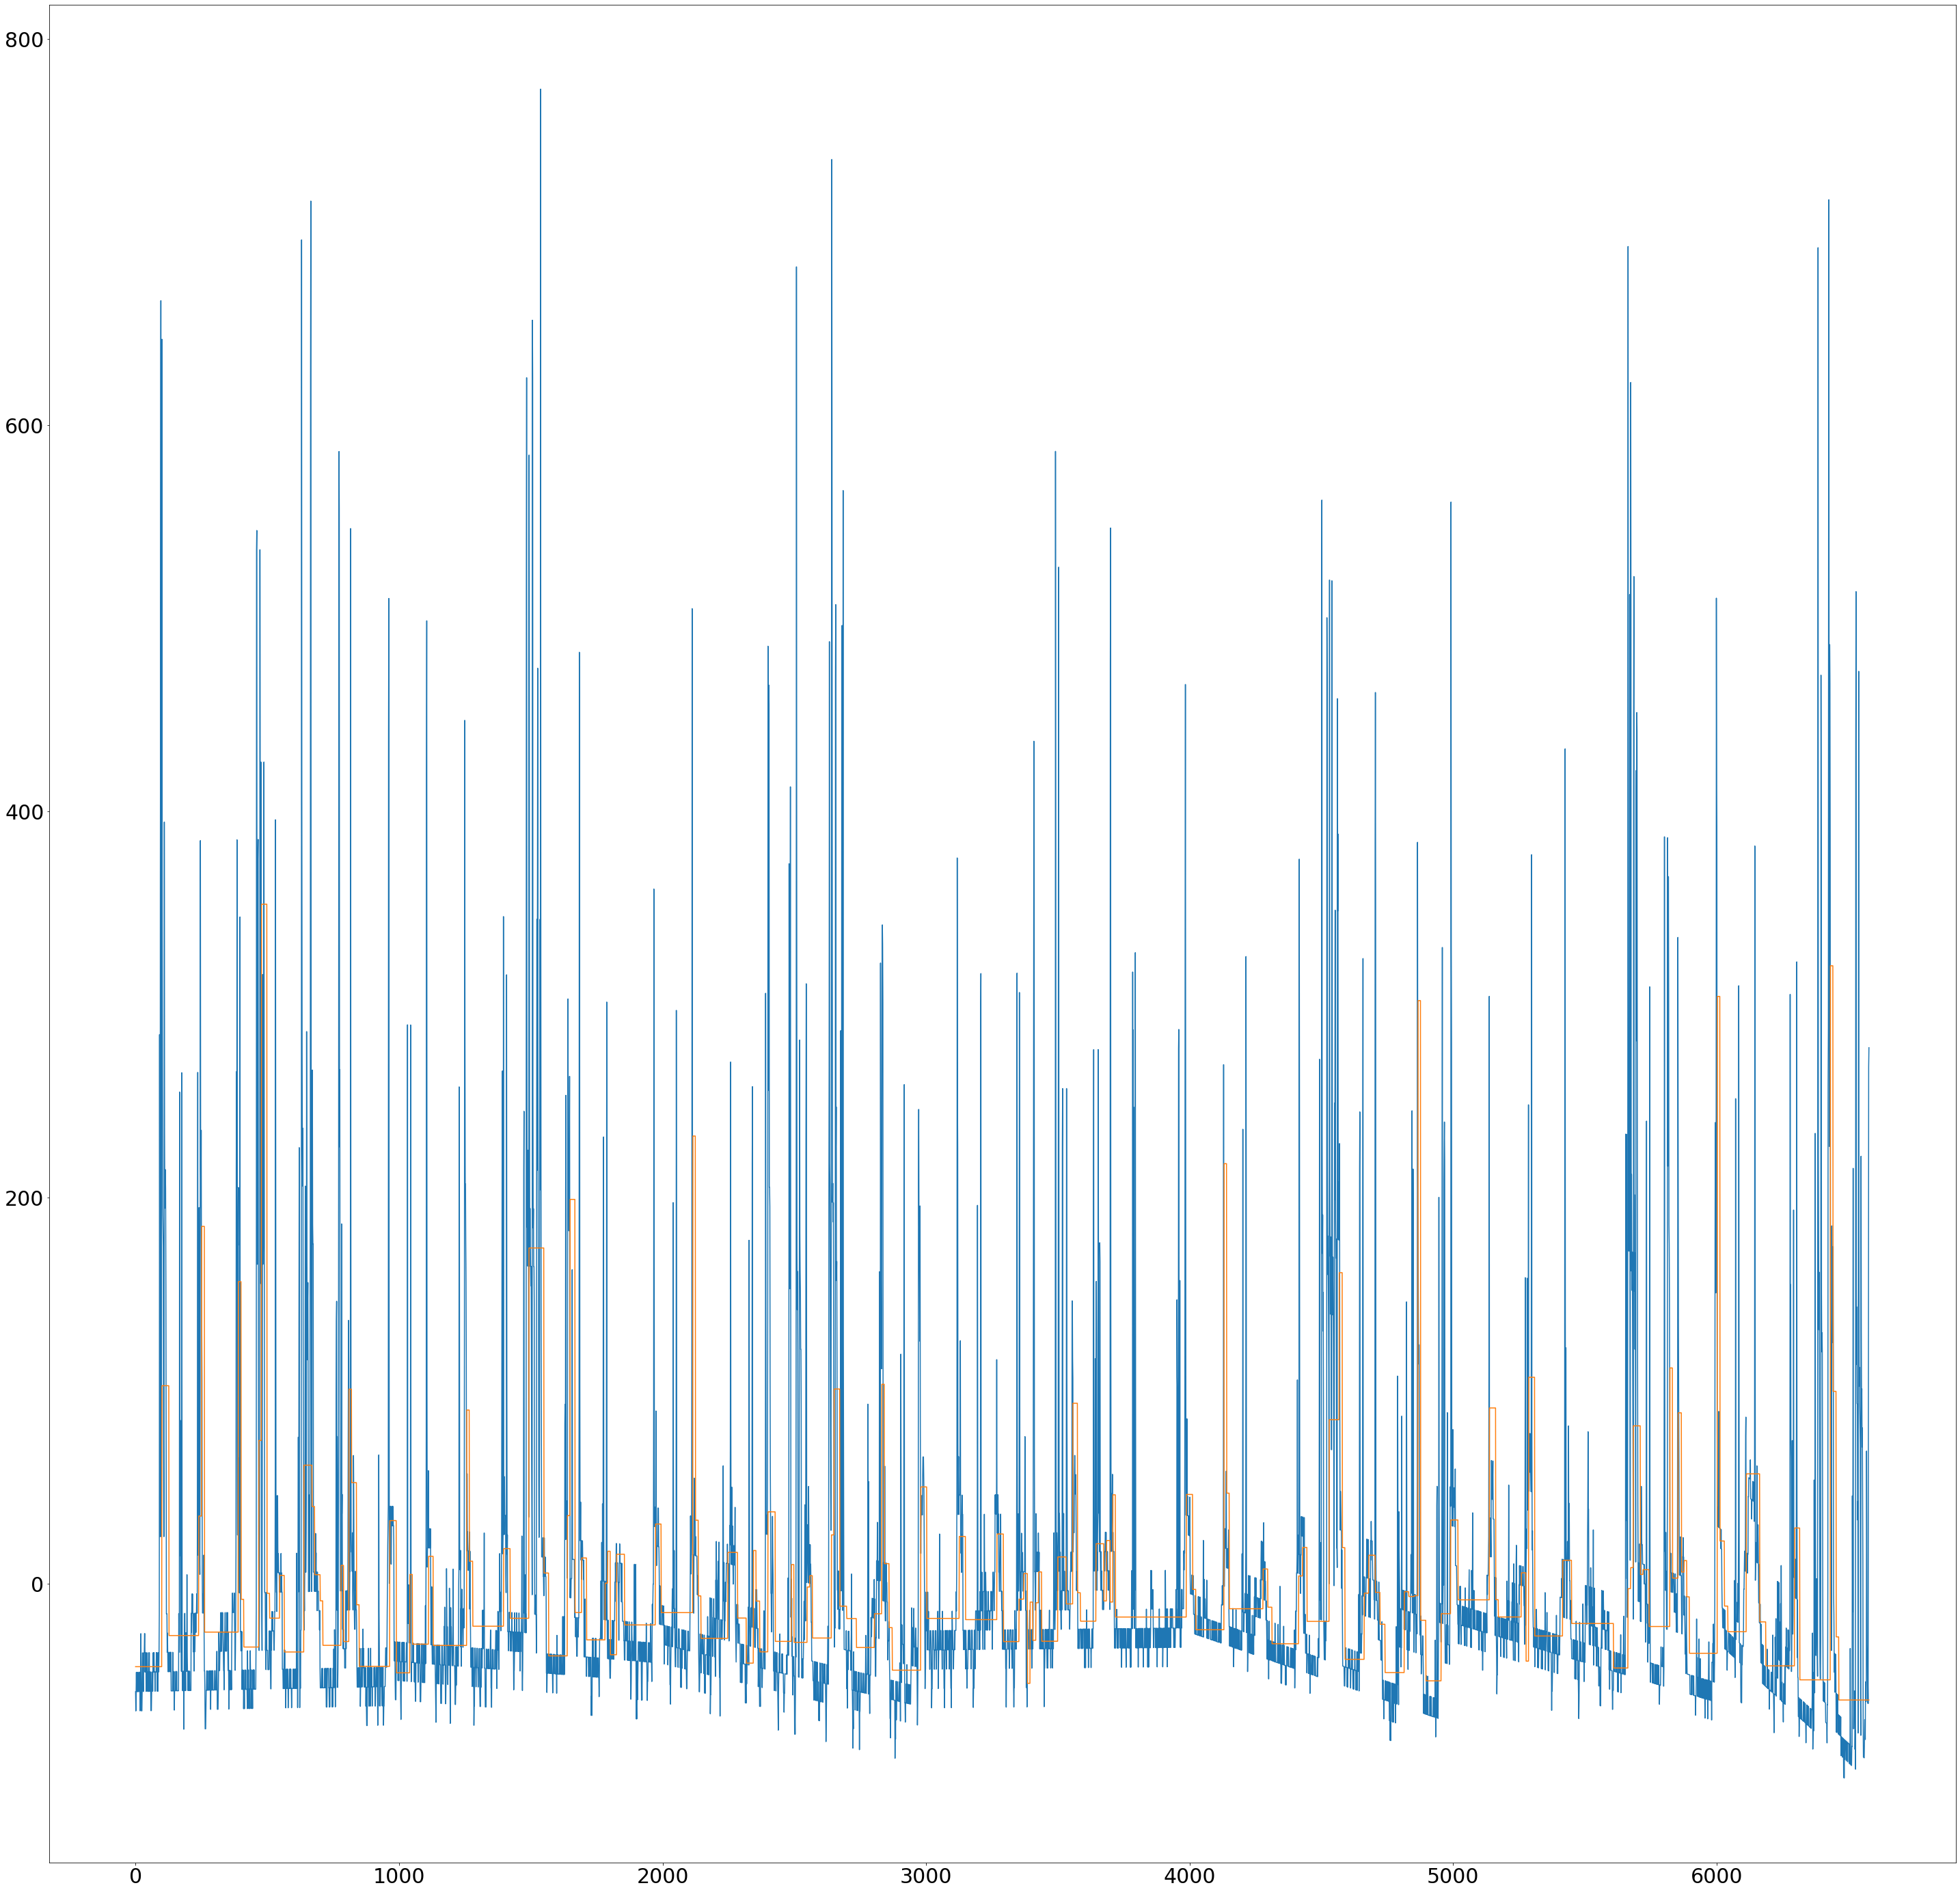

In [48]:
plt.figure(figsize=(50,50))
plt.plot(detrended_sequence_2[three_months+1:])
plt.plot(forecasted_seq_2)
plt.show()

# Plot of the forecasted sequence and the real part of the sequence over which i learned the ARIMA model

In [49]:
print(f"Relative errors over the predicted data, mean: {np.mean(relative_errors_2)}, standard deviation: {np.std(relative_errors_2)}")

Relative errors over the predicted data, mean: 2.30738662544477, standard deviation: 16.50811180902712


In [50]:
MSE_2 = MSE(detrended_sequence_2[three_months+1:], forecasted_seq_2)

print("MSE of the forecasted sequence w.r.t. the last part of the sequence: ", MSE_2)

MSE of the forecasted sequence w.r.t. the last part of the sequence:  8711.370456028086


Showing the distance of the AR learned vector from their centroid (euclidean one), to see how the sequence, encoded by the AR vectors, change over time.

In [51]:
mean_distances_2, std_distances_2 = AR_vectors_statistics(learned_AR_vectors_2)
print(f"Mean distances of the AR vectors learned and their centroids: {mean_distances_2}")
print(f"Standard deviation of the distances of the AR vectors learned and their centroid: {std_distances_2}")

Mean distances of the AR vectors learned and their centroids: 0.008401023788685394
Standard deviation of the distances of the AR vectors learned and their centroid: 0.004061870146236833


We can see that, in the case of the second sequence, the mean and the standard deviation are relativelly small, so the AR models learned are quite similar throught the time.

The number of retrainings are quite similar between the two sequences.

# Trended Sequence 2

Since the we know, and we can see that the second sequence has a linear trend, we can apply ARIMA model with the first order differencing, so setting the 'd' parameter of ARIMA (number of nonseasonal differences) equal to 1.

See the first order differencing sequence

In [13]:
first_order_differencing = trended_sequence[1:] - trended_sequence[:-1]

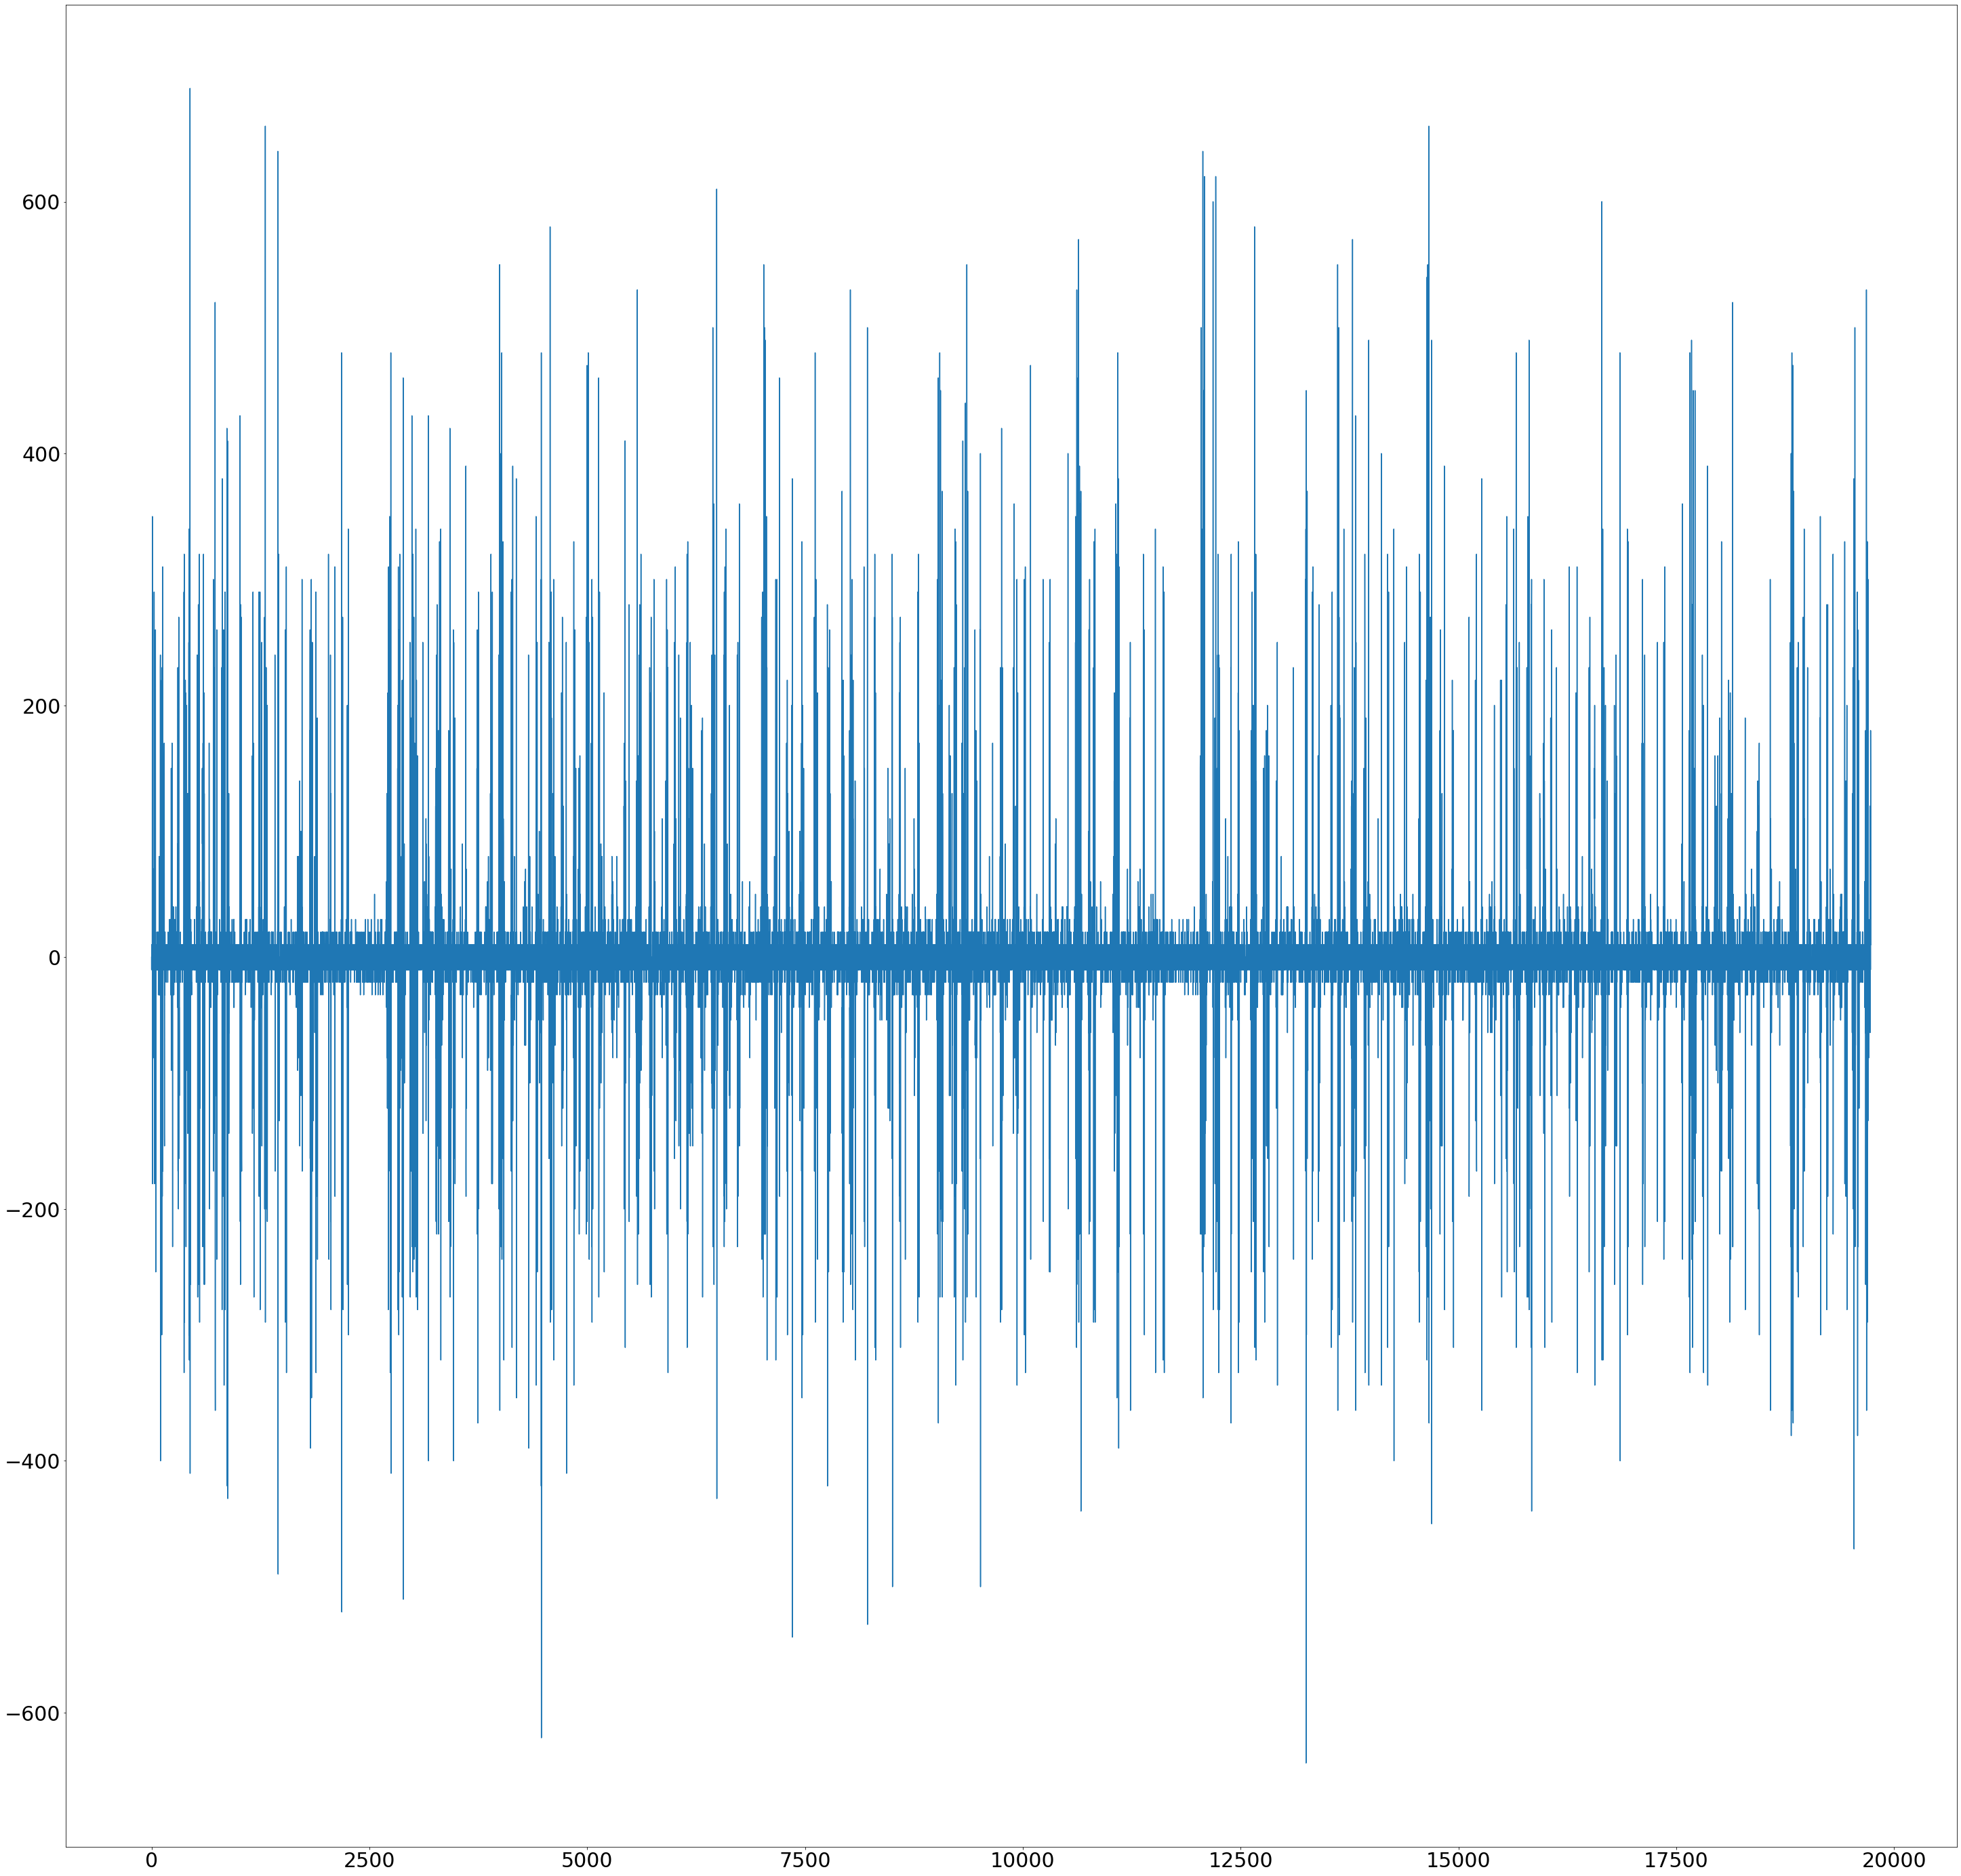

In [54]:
plt.figure(figsize=(50,50))
plt.plot(first_order_differencing)
plt.show()

# Plot of first-order differenciating of the trended function

It's clear from the picture above that the first order differencing has no linear trend anymore

As we said before to do first-order differencing we set the 'd' parameter of ARIMA, arima_args = (p, d, q) equal to 1.

The 'p' parameter is the same of the above executions for the same computational motivations.

In this case to be fair with the other two learn_ARIMA execution we have to take a smaller sensitivity since the scale of the sequence values is different.

In [16]:
forecasted_seq_3, relative_errors_3, learned_AR_vectors_3 = learn_ARIMA(trended_sequence, 10, 0.01, three_months, (3,1,0))

100%|██████████| 6579/6579 [05:21<00:00, 20.49it/s]



Retrains needed:  378


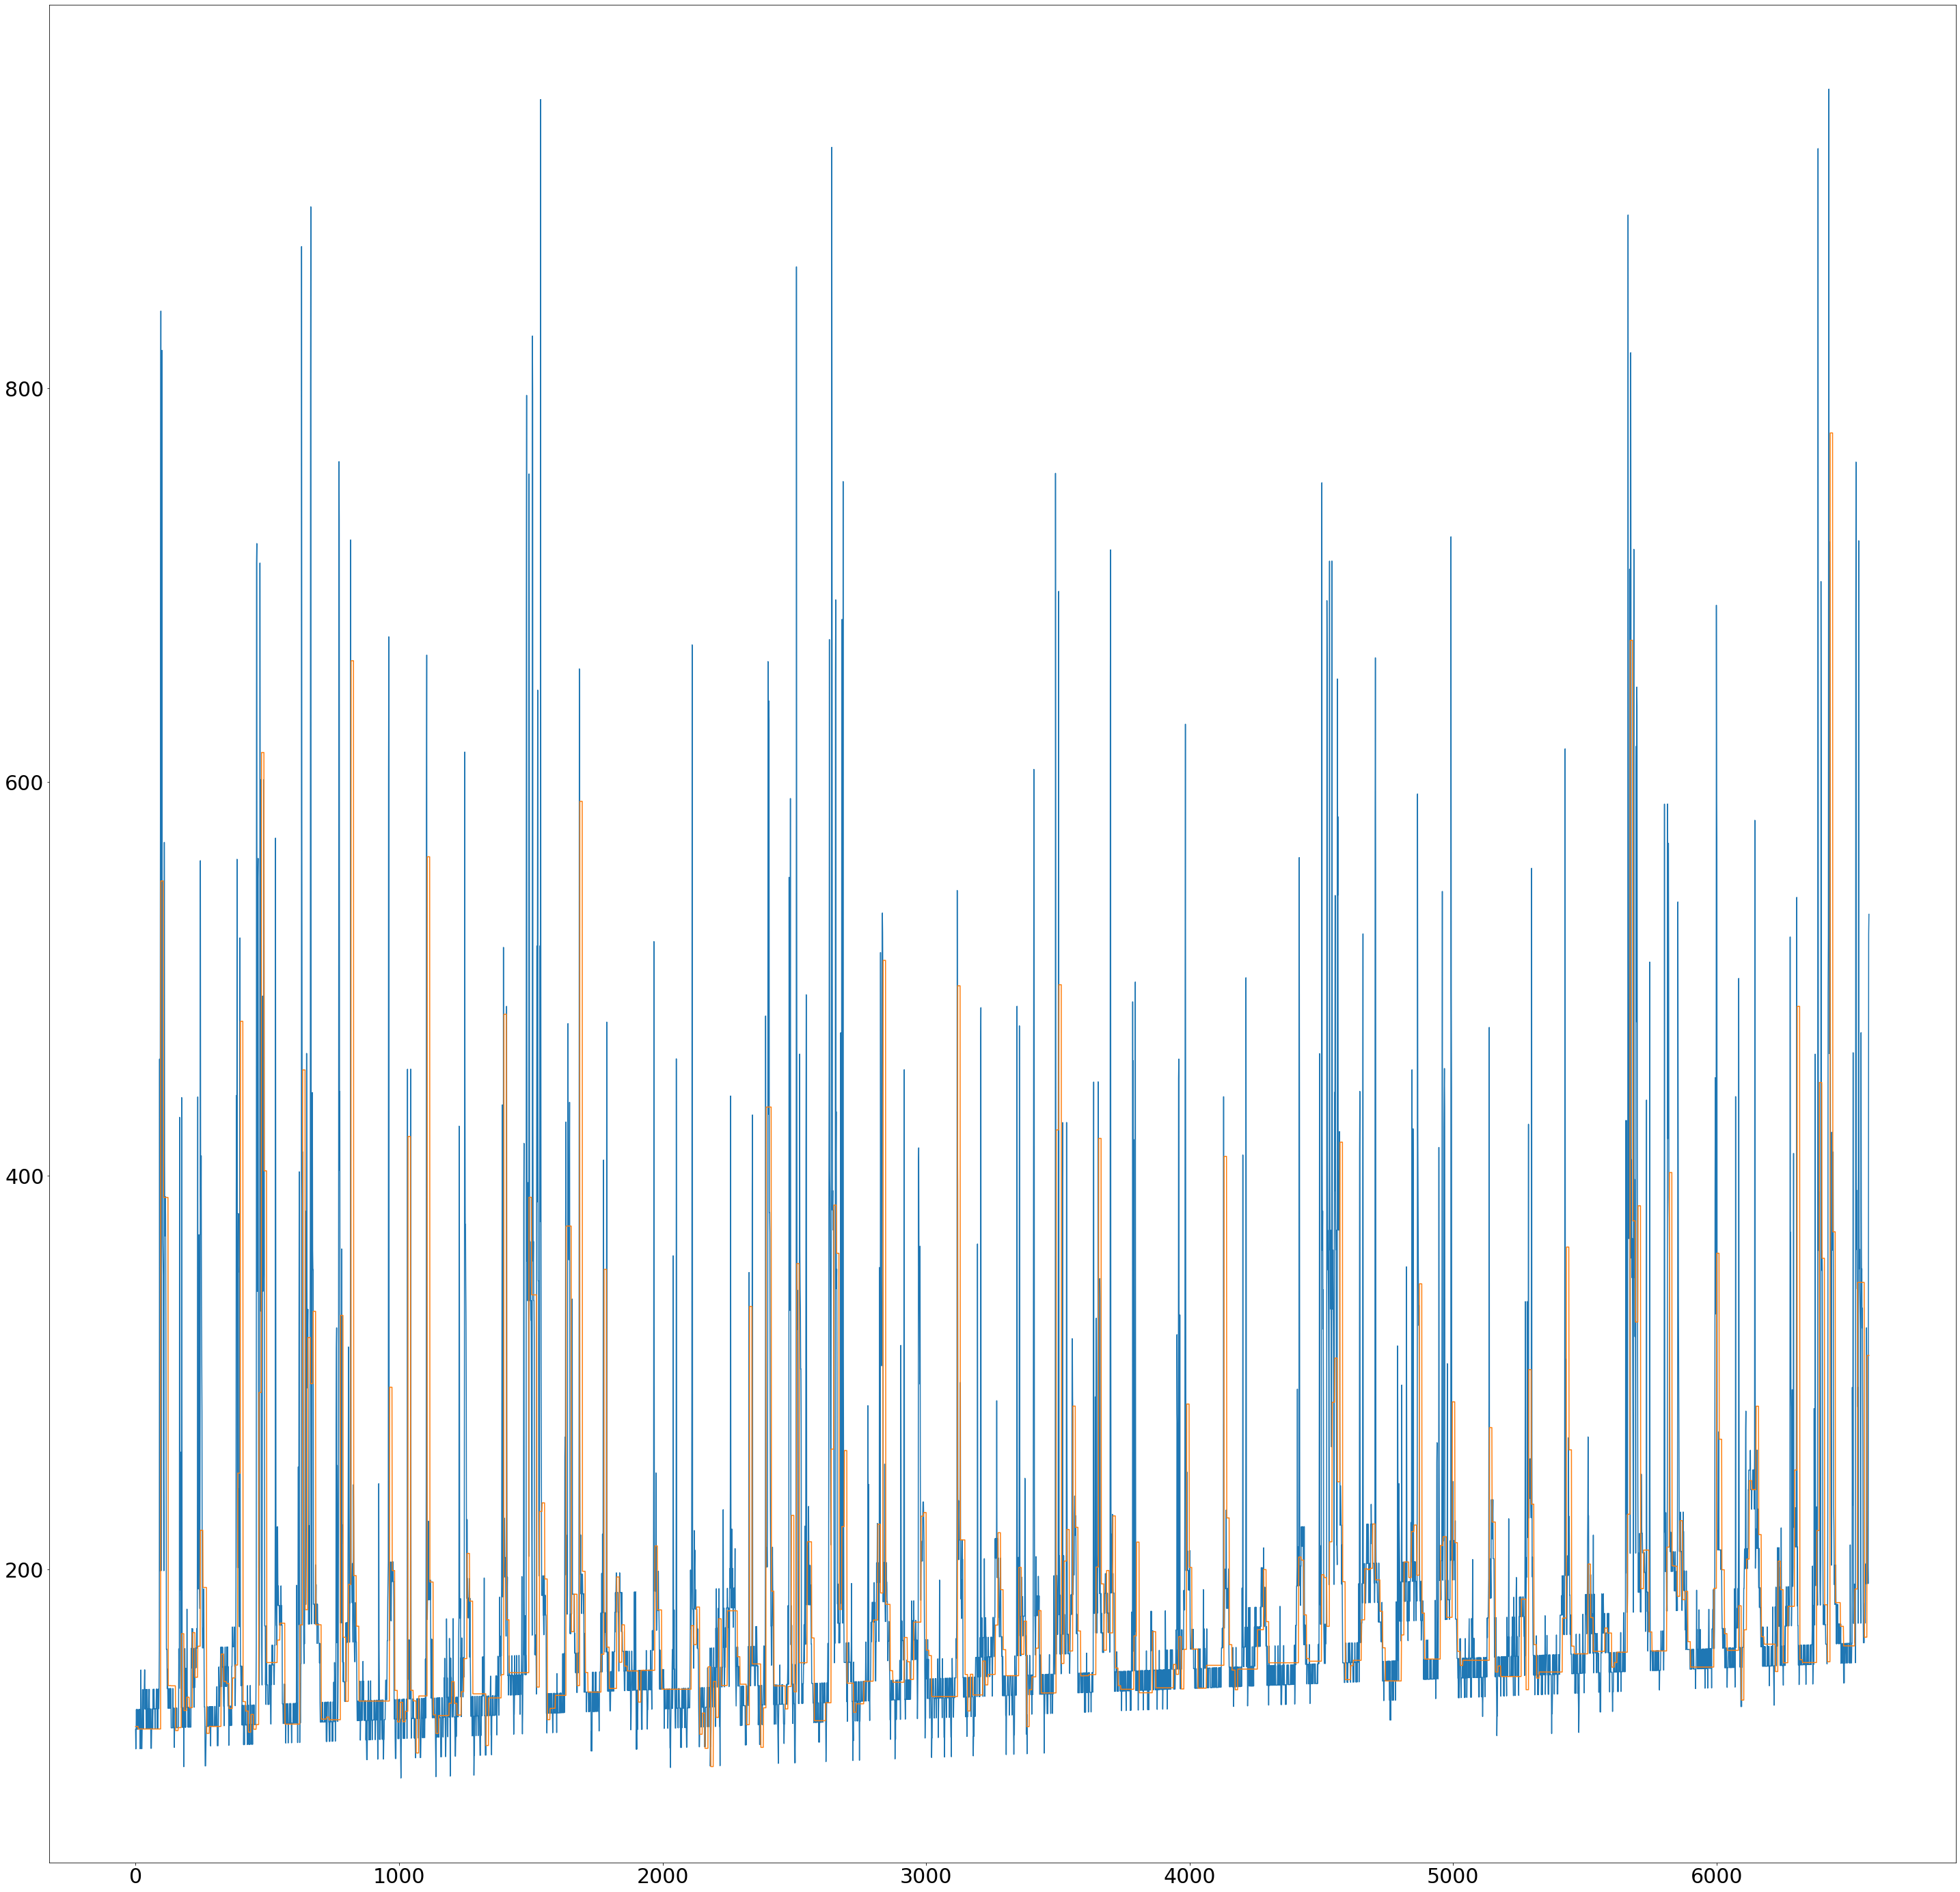

In [60]:
plt.figure(figsize=(50,50))
plt.plot(trended_sequence[three_months+1:])
plt.plot(forecasted_seq_3)
plt.show()

# Plot of the forecasted sequence and the real part of the sequence over which i learned the ARIMA model

In [17]:
print(f"Relative errors over the predicted data, mean: {np.mean(relative_errors_3)}, standard deviation: {np.std(relative_errors_3)}")

Relative errors over the predicted data, mean: 0.207476383886083, standard deviation: 0.3356161877679776


In [18]:
MSE_3 = MSE(trended_sequence[three_months+1:], forecasted_seq_3)

print("MSE of the forecasted sequence w.r.t. the last part of the sequence: ", MSE_3)

MSE of the forecasted sequence w.r.t. the last part of the sequence:  10424.183103388179


Showing the distance of the AR learned vector from their centroid (euclidean one), to see how the sequence, encoded by the AR vectors, change over time.

In [20]:
mean_distances_3, std_distances_3 = AR_vectors_statistics(learned_AR_vectors_3)
print(f"Mean distances of the AR vectors learned and their centroids: {mean_distances_3}")
print(f"Standard deviation of the distances of the AR vectors learned and their centroid: {std_distances_3}")

Mean distances of the AR vectors learned and their centroids: 0.006552644071633572
Standard deviation of the distances of the AR vectors learned and their centroid: 0.002698616073690252


We can see that, even in this case, the mean and the standard deviation are relativelly small, so the AR models learned are quite similar throught the time.